Logistic Regression


Kullanılan cihaz: cuda

LOGİSTİC REGRESSION - TÜM EMBEDDİNG YÖNTEMLERİ KARŞILAŞTIRMASI

1. BERT EMBEDDİNGLERİ ÇIKARILIYOR


BERT embedding: 100%|██████████| 1111/1111 [01:20<00:00, 13.84it/s]


BERT özellik boyutu: (35530, 768)

2. ROBERTA EMBEDDİNGLERİ ÇIKARILIYOR


Some weights of RobertaModel were not initialized from the model checkpoint at TURKCELL/roberta-base-turkish-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
RoBERTa embedding: 100%|██████████| 1111/1111 [01:22<00:00, 13.39it/s]


RoBERTa özellik boyutu: (35530, 768)

3. TF-IDF ÖZELLİKLERİ ÇIKARILIYOR
TF-IDF özellik boyutu: (28424, 5000)

Sınıf dağılımı: Counter({np.int64(0): 23804, np.int64(1): 4620})

5. BERT + LOGİSTİC REGRESSION
BERT + LogReg Test Doğruluğu: 0.7910
BERT + LogReg Test F1: 0.8130
BERT + LogReg CV F1: 0.8124 (+/- 0.0070)

6. ROBERTA + LOGİSTİC REGRESSION
RoBERTa + LogReg Test Doğruluğu: 0.7874
RoBERTa + LogReg Test F1: 0.8098
RoBERTa + LogReg CV F1: 0.8100 (+/- 0.0038)

7. TF-IDF + LOGİSTİC REGRESSION
TF-IDF + LogReg Test Doğruluğu: 0.8040
TF-IDF + LogReg Test F1: 0.8204
TF-IDF + LogReg CV F1: 0.8197 (+/- 0.0030)

8. LOGİSTİC REGRESSION MODEL KARŞILAŞTIRMASI
              Model  Test Accuracy  Test F1-Score  CV F1-Score
2   TF-IDF + LogReg         0.8040         0.8204       0.8197
0     BERT + LogReg         0.7910         0.8130       0.8124
1  RoBERTa + LogReg         0.7874         0.8098       0.8100

En iyi model: TF-IDF + LogReg
En iyi F1-Score: 0.8204

9. DETAYLI DEĞERLENDİRME

--- BERT

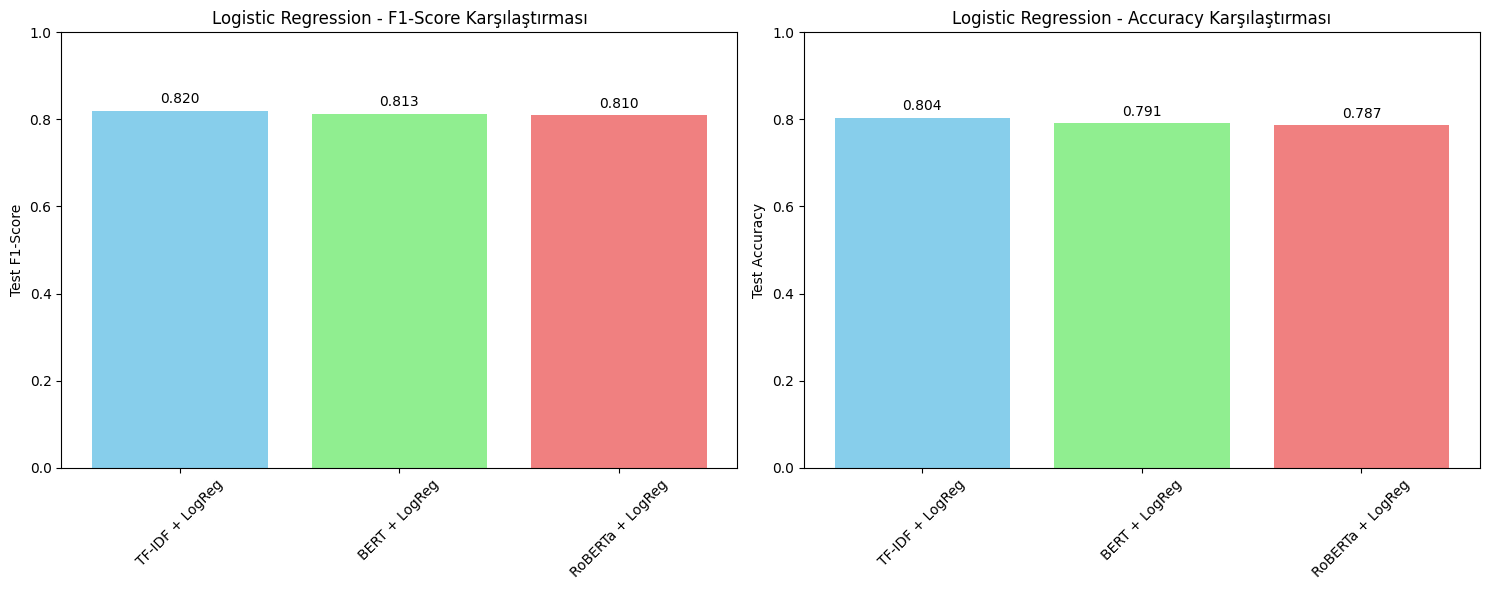

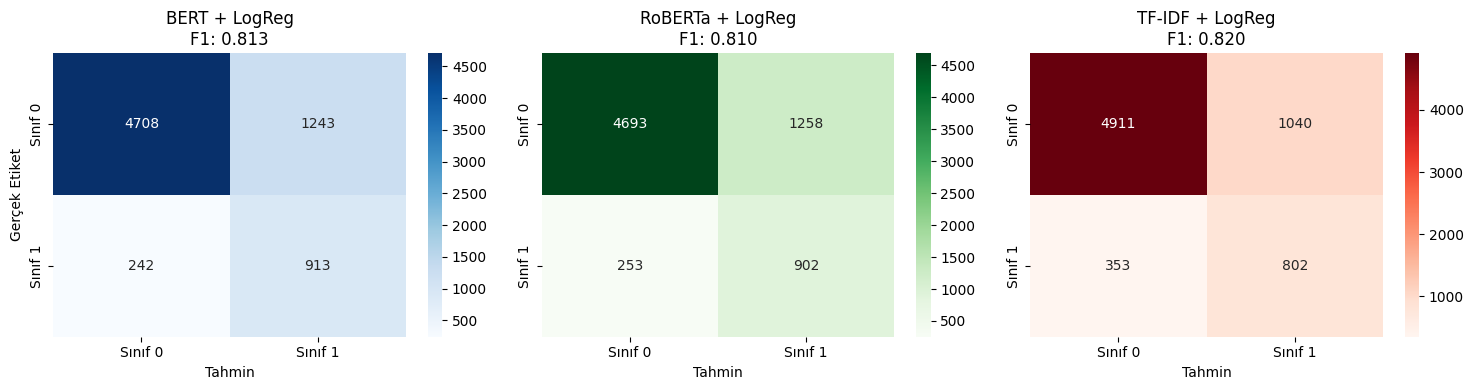

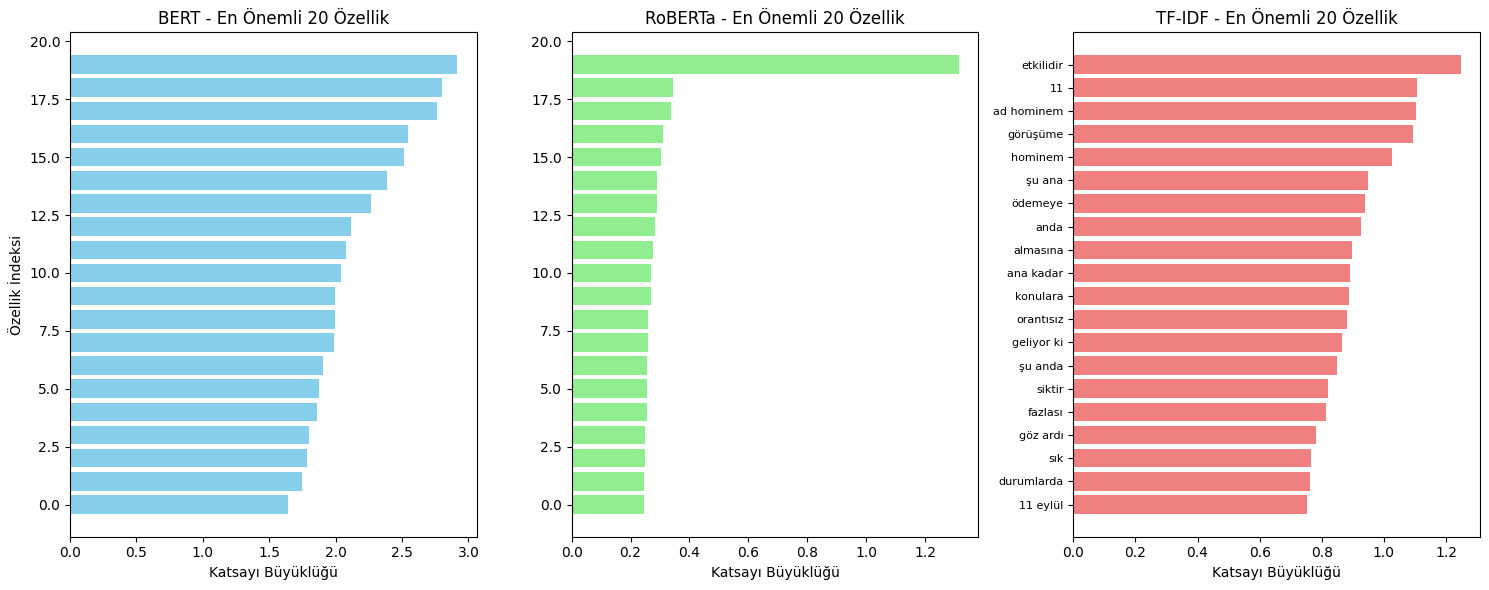

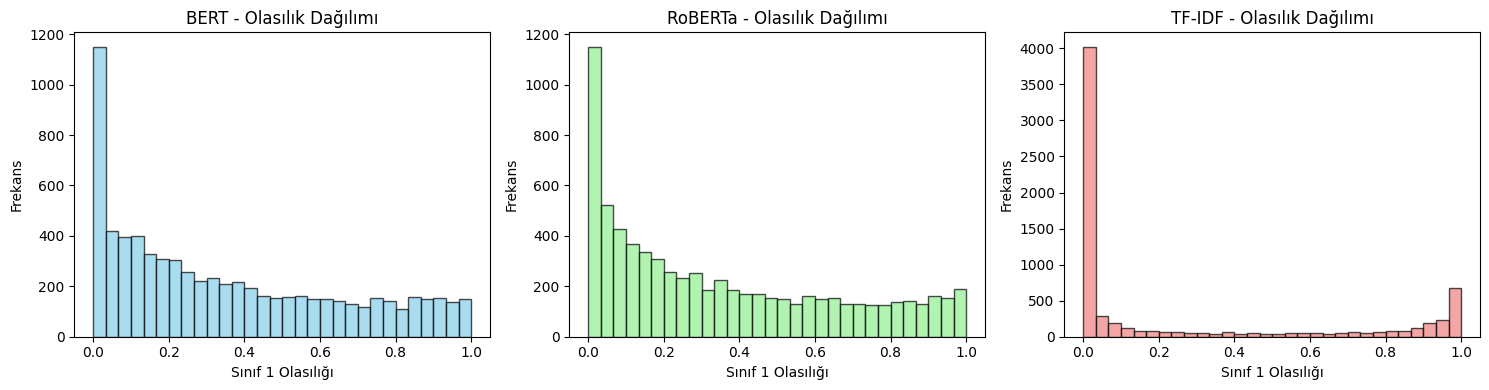


11. MODELLERİ KAYDET
Tüm modeller kaydedildi: logistic_regression_models.pkl

Örnek metin: İklim değişikliği konusundaki argümanlarını neden dinleyelim ki? Kendi evini bile temiz tutamıyor!...
------------------------------------------------------------
BERT + LogReg: Tahmin=0, Olasılık=0.550
RoBERTa + LogReg: Tahmin=1, Olasılık=0.748
TF-IDF + LogReg: Tahmin=1, Olasılık=0.986

SONUÇLARIN ÖZETİ
  Embedding Yöntemi  Test Accuracy  Test F1-Score  CV F1-Score  Özellik Boyutu
0              BERT         0.7910         0.8130       0.8124             768
1           RoBERTa         0.7874         0.8098       0.8100             768
2            TF-IDF         0.8040         0.8204       0.8197            5000

LOGİSTİC REGRESSION - TÜM EMBEDDİNG KARŞILAŞTIRMASI TAMAMLANDI!

ÖZET:
- Toplam 3 embedding yöntemi test edildi
- En iyi model: TF-IDF + LogReg (F1: 0.8204)
- En yüksek accuracy: 0.8040
- Tüm modeller 'logistic_regression_models.pkl' dosyasına kaydedildi


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from transformers import AutoModel, AutoTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib

# Cihaz ayarları
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Veriyi yükle
df = pd.read_csv('dataset.csv')
metinler = df["text"].values.tolist()
labels = df["label"].values

print("\n" + "="*80)
print("LOGİSTİC REGRESSION - TÜM EMBEDDİNG YÖNTEMLERİ KARŞILAŞTIRMASI")
print("="*80)

# ============================================================================
# 1. BERT EMBEDDINGS
# ============================================================================
print("\n" + "="*60)
print("1. BERT EMBEDDİNGLERİ ÇIKARILIYOR")
print("="*60)

# BERT Tokenizer ve model yükle
tokenizer_bert = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
bert_model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased").to(device)

def extract_bert_features(texts, model, tokenizer, max_length=128, batch_size=32):
    """BERT modelinden özellik vektörleri çıkarır"""
    model.eval()
    all_features = []

    for i in tqdm(range(0, len(texts), batch_size), desc="BERT embedding"):
        batch_texts = texts[i:i+batch_size]

        encoding = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.pooler_output.cpu().numpy()
            all_features.append(features)

    return np.vstack(all_features)

bert_features = extract_bert_features(metinler, bert_model, tokenizer_bert)
print(f"BERT özellik boyutu: {bert_features.shape}")

# ============================================================================
# 2. ROBERTA EMBEDDINGS
# ============================================================================
print("\n" + "="*60)
print("2. ROBERTA EMBEDDİNGLERİ ÇIKARILIYOR")
print("="*60)

# RoBERTa Tokenizer ve model yükle
tokenizer_roberta = AutoTokenizer.from_pretrained("TURKCELL/roberta-base-turkish-uncased")
roberta_model = AutoModel.from_pretrained("TURKCELL/roberta-base-turkish-uncased").to(device)

def extract_roberta_features(texts, model, tokenizer, max_length=128, batch_size=32):
    """RoBERTa modelinden özellik vektörleri çıkarır"""
    model.eval()
    all_features = []

    for i in tqdm(range(0, len(texts), batch_size), desc="RoBERTa embedding"):
        batch_texts = texts[i:i+batch_size]

        encoding = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # RoBERTa için last_hidden_state'in ortalamasını kullan
            features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_features.append(features)

    return np.vstack(all_features)

roberta_features = extract_roberta_features(metinler, roberta_model, tokenizer_roberta)
print(f"RoBERTa özellik boyutu: {roberta_features.shape}")

# ============================================================================
# 3. TF-IDF FEATURES
# ============================================================================
print("\n" + "="*60)
print("3. TF-IDF ÖZELLİKLERİ ÇIKARILIYOR")
print("="*60)

# Text için train/test split
metinler_train, metinler_test, y_train_text, y_test_text = train_test_split(
    metinler, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# TF-IDF vektörleştirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    lowercase=True,
    max_df=0.95,
    min_df=2
)

# TF-IDF özellikleri
tfidf_train = tfidf_vectorizer.fit_transform(metinler_train)
tfidf_test = tfidf_vectorizer.transform(metinler_test)

# Dense format'a çevir
tfidf_train_dense = tfidf_train.toarray()
tfidf_test_dense = tfidf_test.toarray()

print(f"TF-IDF özellik boyutu: {tfidf_train_dense.shape}")

# ============================================================================
# 4. VERİ BÖLME VE ÖN İŞLEME
# ============================================================================

# BERT için train/test split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# RoBERTa için train/test split
X_train_roberta, X_test_roberta, y_train_roberta, y_test_roberta = train_test_split(
    roberta_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Sınıf dağılımı kontrolü
from collections import Counter
class_counts = Counter(y_train_bert)
print(f"\nSınıf dağılımı: {class_counts}")

# ============================================================================
# 5. BERT + LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*60)
print("5. BERT + LOGİSTİC REGRESSION")
print("="*60)

# BERT özellikleri için scaler
scaler_bert = StandardScaler()
X_train_bert_scaled = scaler_bert.fit_transform(X_train_bert)
X_test_bert_scaled = scaler_bert.transform(X_test_bert)

# Logistic Regression modeli (BERT)
lr_bert = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

# Modeli eğit
lr_bert.fit(X_train_bert_scaled, y_train_bert)

# Tahminler
y_pred_test_bert = lr_bert.predict(X_test_bert_scaled)
y_proba_test_bert = lr_bert.predict_proba(X_test_bert_scaled)

# Performans metrikleri
test_acc_bert = accuracy_score(y_test_bert, y_pred_test_bert)
test_f1_bert = f1_score(y_test_bert, y_pred_test_bert, average='weighted')
cv_scores_bert = cross_val_score(lr_bert, X_train_bert_scaled, y_train_bert, cv=5, scoring='f1_weighted')

print(f"BERT + LogReg Test Doğruluğu: {test_acc_bert:.4f}")
print(f"BERT + LogReg Test F1: {test_f1_bert:.4f}")
print(f"BERT + LogReg CV F1: {cv_scores_bert.mean():.4f} (+/- {cv_scores_bert.std() * 2:.4f})")

# ============================================================================
# 6. ROBERTA + LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*60)
print("6. ROBERTA + LOGİSTİC REGRESSION")
print("="*60)

# RoBERTa özellikleri için scaler
scaler_roberta = StandardScaler()
X_train_roberta_scaled = scaler_roberta.fit_transform(X_train_roberta)
X_test_roberta_scaled = scaler_roberta.transform(X_test_roberta)

# Logistic Regression modeli (RoBERTa)
lr_roberta = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

# Modeli eğit
lr_roberta.fit(X_train_roberta_scaled, y_train_roberta)

# Tahminler
y_pred_test_roberta = lr_roberta.predict(X_test_roberta_scaled)
y_proba_test_roberta = lr_roberta.predict_proba(X_test_roberta_scaled)

# Performans metrikleri
test_acc_roberta = accuracy_score(y_test_roberta, y_pred_test_roberta)
test_f1_roberta = f1_score(y_test_roberta, y_pred_test_roberta, average='weighted')
cv_scores_roberta = cross_val_score(lr_roberta, X_train_roberta_scaled, y_train_roberta, cv=5, scoring='f1_weighted')

print(f"RoBERTa + LogReg Test Doğruluğu: {test_acc_roberta:.4f}")
print(f"RoBERTa + LogReg Test F1: {test_f1_roberta:.4f}")
print(f"RoBERTa + LogReg CV F1: {cv_scores_roberta.mean():.4f} (+/- {cv_scores_roberta.std() * 2:.4f})")

# ============================================================================
# 7. TF-IDF + LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*60)
print("7. TF-IDF + LOGİSTİC REGRESSION")
print("="*60)

# TF-IDF özellikleri için scaler
scaler_tfidf = StandardScaler()
X_train_tfidf_scaled = scaler_tfidf.fit_transform(tfidf_train_dense)
X_test_tfidf_scaled = scaler_tfidf.transform(tfidf_test_dense)

# Logistic Regression modeli (TF-IDF)
lr_tfidf = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

# Modeli eğit
lr_tfidf.fit(X_train_tfidf_scaled, y_train_text)

# Tahminler
y_pred_test_tfidf = lr_tfidf.predict(X_test_tfidf_scaled)
y_proba_test_tfidf = lr_tfidf.predict_proba(X_test_tfidf_scaled)

# Performans metrikleri
test_acc_tfidf = accuracy_score(y_test_text, y_pred_test_tfidf)
test_f1_tfidf = f1_score(y_test_text, y_pred_test_tfidf, average='weighted')
cv_scores_tfidf = cross_val_score(lr_tfidf, X_train_tfidf_scaled, y_train_text, cv=5, scoring='f1_weighted')

print(f"TF-IDF + LogReg Test Doğruluğu: {test_acc_tfidf:.4f}")
print(f"TF-IDF + LogReg Test F1: {test_f1_tfidf:.4f}")
print(f"TF-IDF + LogReg CV F1: {cv_scores_tfidf.mean():.4f} (+/- {cv_scores_tfidf.std() * 2:.4f})")

# ============================================================================
# 8. MODEL KARŞILAŞTIRMASI
# ============================================================================
print("\n" + "="*60)
print("8. LOGİSTİC REGRESSION MODEL KARŞILAŞTIRMASI")
print("="*60)

# Karşılaştırma tablosu
comparison_data = {
    'Model': ['BERT + LogReg', 'RoBERTa + LogReg', 'TF-IDF + LogReg'],
    'Test Accuracy': [test_acc_bert, test_acc_roberta, test_acc_tfidf],
    'Test F1-Score': [test_f1_bert, test_f1_roberta, test_f1_tfidf],
    'CV F1-Score': [cv_scores_bert.mean(), cv_scores_roberta.mean(), cv_scores_tfidf.mean()]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test F1-Score', ascending=False)
print(comparison_df.round(4))

# En iyi modeli belirle
best_idx = comparison_df.index[0]
best_model_name = comparison_df.loc[best_idx, 'Model']
best_f1 = comparison_df.loc[best_idx, 'Test F1-Score']
print(f"\nEn iyi model: {best_model_name}")
print(f"En iyi F1-Score: {best_f1:.4f}")

# ============================================================================
# 9. DETAYLI DEĞERLENDIRME
# ============================================================================
print("\n" + "="*60)
print("9. DETAYLI DEĞERLENDİRME")
print("="*60)

# Her model için detaylı rapor
print("\n--- BERT + Logistic Regression ---")
print(classification_report(y_test_bert, y_pred_test_bert))

print("\n--- RoBERTa + Logistic Regression ---")
print(classification_report(y_test_roberta, y_pred_test_roberta))

print("\n--- TF-IDF + Logistic Regression ---")
print(classification_report(y_test_text, y_pred_test_tfidf))

# ============================================================================
# 10. GÖRSELLEŞTİRMELER
# ============================================================================
print("\n" + "="*60)
print("10. GÖRSELLEŞTİRMELER")
print("="*60)

# Performance comparison bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# F1-Score karşılaştırması
models = comparison_df['Model'].values
f1_scores = comparison_df['Test F1-Score'].values
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars1 = ax1.bar(models, f1_scores, color=colors)
ax1.set_ylabel('Test F1-Score')
ax1.set_title('Logistic Regression - F1-Score Karşılaştırması')
ax1.set_ylim(0, 1)
ax1.tick_params(axis='x', rotation=45)

# Value labels ekle
for bar, f1 in zip(bars1, f1_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{f1:.3f}', ha='center', va='bottom')

# Accuracy karşılaştırması
accuracies = comparison_df['Test Accuracy'].values
bars2 = ax2.bar(models, accuracies, color=colors)
ax2.set_ylabel('Test Accuracy')
ax2.set_title('Logistic Regression - Accuracy Karşılaştırması')
ax2.set_ylim(0, 1)
ax2.tick_params(axis='x', rotation=45)

# Value labels ekle
for bar, acc in zip(bars2, accuracies):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# BERT confusion matrix
cm_bert = confusion_matrix(y_test_bert, y_pred_test_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Sınıf 0', 'Sınıf 1'],
            yticklabels=['Sınıf 0', 'Sınıf 1'])
axes[0].set_title(f'BERT + LogReg\nF1: {test_f1_bert:.3f}')
axes[0].set_ylabel('Gerçek Etiket')
axes[0].set_xlabel('Tahmin')

# RoBERTa confusion matrix
cm_roberta = confusion_matrix(y_test_roberta, y_pred_test_roberta)
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Sınıf 0', 'Sınıf 1'],
            yticklabels=['Sınıf 0', 'Sınıf 1'])
axes[1].set_title(f'RoBERTa + LogReg\nF1: {test_f1_roberta:.3f}')
axes[1].set_xlabel('Tahmin')

# TF-IDF confusion matrix
cm_tfidf = confusion_matrix(y_test_text, y_pred_test_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Reds', ax=axes[2],
            xticklabels=['Sınıf 0', 'Sınıf 1'],
            yticklabels=['Sınıf 0', 'Sınıf 1'])
axes[2].set_title(f'TF-IDF + LogReg\nF1: {test_f1_tfidf:.3f}')
axes[2].set_xlabel('Tahmin')

plt.tight_layout()
plt.show()

# Feature importance comparison for top features
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# BERT feature importance
feature_importance_bert = abs(lr_bert.coef_[0])
top_features_bert = np.argsort(feature_importance_bert)[-20:]
axes[0].barh(range(20), feature_importance_bert[top_features_bert], color='skyblue')
axes[0].set_xlabel('Katsayı Büyüklüğü')
axes[0].set_ylabel('Özellik İndeksi')
axes[0].set_title('BERT - En Önemli 20 Özellik')

# RoBERTa feature importance
feature_importance_roberta = abs(lr_roberta.coef_[0])
top_features_roberta = np.argsort(feature_importance_roberta)[-20:]
axes[1].barh(range(20), feature_importance_roberta[top_features_roberta], color='lightgreen')
axes[1].set_xlabel('Katsayı Büyüklüğü')
axes[1].set_title('RoBERTa - En Önemli 20 Özellik')

# TF-IDF feature importance
feature_importance_tfidf = abs(lr_tfidf.coef_[0])
top_features_tfidf = np.argsort(feature_importance_tfidf)[-20:]

# TF-IDF için özellik isimlerini al
feature_names = tfidf_vectorizer.get_feature_names_out()
top_feature_names = [feature_names[i] for i in top_features_tfidf]

axes[2].barh(range(20), feature_importance_tfidf[top_features_tfidf], color='lightcoral')
axes[2].set_xlabel('Katsayı Büyüklüğü')
axes[2].set_title('TF-IDF - En Önemli 20 Özellik')
axes[2].set_yticks(range(20))
axes[2].set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in top_feature_names], fontsize=8)

plt.tight_layout()
plt.show()

# Probability distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# BERT probability distribution
axes[0].hist(y_proba_test_bert[:, 1], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Sınıf 1 Olasılığı')
axes[0].set_ylabel('Frekans')
axes[0].set_title('BERT - Olasılık Dağılımı')

# RoBERTa probability distribution
axes[1].hist(y_proba_test_roberta[:, 1], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Sınıf 1 Olasılığı')
axes[1].set_ylabel('Frekans')
axes[1].set_title('RoBERTa - Olasılık Dağılımı')

# TF-IDF probability distribution
axes[2].hist(y_proba_test_tfidf[:, 1], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[2].set_xlabel('Sınıf 1 Olasılığı')
axes[2].set_ylabel('Frekans')
axes[2].set_title('TF-IDF - Olasılık Dağılımı')

plt.tight_layout()
plt.show()

# ============================================================================
# 11. MODELLERİ KAYDET
# ============================================================================
print("\n" + "="*60)
print("11. MODELLERİ KAYDET")
print("="*60)

# Tüm modelleri kaydet
models_package = {
    'bert_logistic': {
        'model': lr_bert,
        'scaler': scaler_bert,
        'tokenizer': tokenizer_bert,
        'bert_model': bert_model
    },
    'roberta_logistic': {
        'model': lr_roberta,
        'scaler': scaler_roberta,
        'tokenizer': tokenizer_roberta,
        'roberta_model': roberta_model
    },
    'tfidf_logistic': {
        'model': lr_tfidf,
        'scaler': scaler_tfidf,
        'vectorizer': tfidf_vectorizer
    },
    'comparison_results': comparison_df
}

joblib.dump(models_package, 'logistic_regression_models.pkl')
print("Tüm modeller kaydedildi: logistic_regression_models.pkl")

# ============================================================================
# 12. TAHMİN FONKSİYONLARI
# ============================================================================

def predict_with_bert_logistic(text, model_dict):
    """BERT + LogisticRegression ile tahmin"""
    encoding = model_dict['tokenizer']([text], padding=True, truncation=True,
                                      max_length=128, return_tensors='pt')

    model_dict['bert_model'].eval()
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model_dict['bert_model'](input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.pooler_output.cpu().numpy()

    features_scaled = model_dict['scaler'].transform(features)
    prediction = model_dict['model'].predict(features_scaled)[0]
    probability = model_dict['model'].predict_proba(features_scaled)[0]

    return prediction, probability

def predict_with_roberta_logistic(text, model_dict):
    """RoBERTa + LogisticRegression ile tahmin"""
    encoding = model_dict['tokenizer']([text], padding=True, truncation=True,
                                      max_length=128, return_tensors='pt')

    model_dict['roberta_model'].eval()
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model_dict['roberta_model'](input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

    features_scaled = model_dict['scaler'].transform(features)
    prediction = model_dict['model'].predict(features_scaled)[0]
    probability = model_dict['model'].predict_proba(features_scaled)[0]

    return prediction, probability

def predict_with_tfidf_logistic(text, model_dict):
    """TF-IDF + LogisticRegression ile tahmin"""
    features = model_dict['vectorizer'].transform([text]).toarray()
    features_scaled = model_dict['scaler'].transform(features)
    prediction = model_dict['model'].predict(features_scaled)[0]
    probability = model_dict['model'].predict_proba(features_scaled)[0]

    return prediction, probability

# Örnek tahminler
if len(metinler) > 0:
    sample_text = metinler[0]
    print(f"\nÖrnek metin: {sample_text[:100]}...")
    print("-" * 60)

    pred_bert, prob_bert = predict_with_bert_logistic(sample_text, models_package['bert_logistic'])
    print(f"BERT + LogReg: Tahmin={pred_bert}, Olasılık={prob_bert[pred_bert]:.3f}")

    pred_roberta, prob_roberta = predict_with_roberta_logistic(sample_text, models_package['roberta_logistic'])
    print(f"RoBERTa + LogReg: Tahmin={pred_roberta}, Olasılık={prob_roberta[pred_roberta]:.3f}")

    pred_tfidf, prob_tfidf = predict_with_tfidf_logistic(sample_text, models_package['tfidf_logistic'])
    print(f"TF-IDF + LogReg: Tahmin={pred_tfidf}, Olasılık={prob_tfidf[pred_tfidf]:.3f}")

# Sonuçların özet tablosu
print("\n" + "="*60)
print("SONUÇLARIN ÖZETİ")
print("="*60)

results_summary = pd.DataFrame({
    'Embedding Yöntemi': ['BERT', 'RoBERTa', 'TF-IDF'],
    'Test Accuracy': [test_acc_bert, test_acc_roberta, test_acc_tfidf],
    'Test F1-Score': [test_f1_bert, test_f1_roberta, test_f1_tfidf],
    'CV F1-Score': [cv_scores_bert.mean(), cv_scores_roberta.mean(), cv_scores_tfidf.mean()],
    'Özellik Boyutu': [bert_features.shape[1], roberta_features.shape[1], tfidf_train_dense.shape[1]]
})

print(results_summary.round(4))

print("\n" + "="*80)
print("LOGİSTİC REGRESSION - TÜM EMBEDDİNG KARŞILAŞTIRMASI TAMAMLANDI!")
print("="*80)

# Final özet
print(f"\nÖZET:")
print(f"- Toplam 3 embedding yöntemi test edildi")
print(f"- En iyi model: {best_model_name} (F1: {best_f1:.4f})")
print(f"- En yüksek accuracy: {comparison_df['Test Accuracy'].max():.4f}")
print(f"- Tüm modeller 'logistic_regression_models.pkl' dosyasına kaydedildi")

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
# İlk çalıştırmada gerekli
# nltk.download('punkt')

# Constants
RANDOM_STATE = 42
EMBEDDING_DIM = 100   # FastText/Word2Vec embedding boyutu
MAX_SEQ_LENGTH = 100  # Maksimum sequence uzunluğu

print(f"Starting Logistic Regression training...")

class TextPreprocessor:
    def __init__(self, max_seq_length=MAX_SEQ_LENGTH):
        self.max_seq_length = max_seq_length
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        self.vocab_size = 2

    def clean_text(self, text):
        """Metni temizle"""
        text = text.lower()
        text = re.sub(r'[^a-zA-ZğüşıöçĞÜŞIÖÇ\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize_text(self, text):
        """Metni tokenize et"""
        try:
            tokens = word_tokenize(text)
        except:
            tokens = text.split()
        return tokens

    def build_vocab_from_texts(self, texts):
        """Metinlerden vocabulary oluştur"""
        word_count = Counter()

        for text in texts:
            cleaned_text = self.clean_text(text)
            tokens = self.tokenize_text(cleaned_text)
            word_count.update(tokens)

        # Sadece 2'den fazla geçen kelimeleri al
        for word, count in word_count.items():
            if count >= 2 and word not in self.word_to_idx:
                self.word_to_idx[word] = self.vocab_size
                self.idx_to_word[self.vocab_size] = word
                self.vocab_size += 1

        print(f"Vocabulary size: {self.vocab_size}")

    def text_to_tokens(self, text):
        """Metni token listesine çevir"""
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize_text(cleaned_text)
        return tokens

    def texts_to_token_lists(self, texts):
        """Birden fazla metni token listelerine çevir"""
        token_lists = []
        for text in texts:
            tokens = self.text_to_tokens(text)
            token_lists.append(tokens)
        return token_lists

class EmbeddingLoader:
    def __init__(self, embedding_path, embedding_dim=EMBEDDING_DIM):
        self.embedding_path = embedding_path
        self.embedding_dim = embedding_dim
        self.embeddings = None

    def load_embeddings(self):
        """NPY dosyasından embeddings yükle"""
        print(f"Loading embeddings from {self.embedding_path}")
        self.embeddings = np.load(self.embedding_path)
        print(f"Embeddings shape: {self.embeddings.shape}")
        return self.embeddings

    def create_embedding_matrix(self, word_to_idx, vocab_size):
        """Vocabulary için embedding matrix oluştur"""
        if self.embeddings is None:
            self.load_embeddings()

        # Embedding matrix oluştur
        embedding_matrix = np.random.normal(0, 0.1, (vocab_size, self.embedding_dim))

        # <PAD> token için sıfır vektör
        embedding_matrix[0] = np.zeros(self.embedding_dim)

        # TODO: NPY dosyasının formatına göre embedding eşleştirmesi
        # Şu an random initialization kullanıyoruz

        return embedding_matrix.astype(np.float32)

class EmbeddingAggregator:
    """
    Text'leri embedding'lere çevirip aggregate eden sınıf
    """
    def __init__(self, embedding_matrix, word_to_idx):
        self.embedding_matrix = embedding_matrix
        self.word_to_idx = word_to_idx

    def tokens_to_embeddings(self, tokens):
        """Token listesini embedding listesine çevir"""
        embeddings = []
        for token in tokens:
            if token in self.word_to_idx:
                idx = self.word_to_idx[token]
                embeddings.append(self.embedding_matrix[idx])
            else:
                # UNK token embedding'i
                embeddings.append(self.embedding_matrix[1])

        if not embeddings:
            # Boş text için PAD embedding
            embeddings.append(self.embedding_matrix[0])

        return np.array(embeddings)

    def aggregate_embeddings(self, embeddings, method='mean'):
        """Embedding'leri aggregate et"""
        if method == 'mean':
            return np.mean(embeddings, axis=0)
        elif method == 'max':
            return np.max(embeddings, axis=0)
        elif method == 'sum':
            return np.sum(embeddings, axis=0)
        elif method == 'min':
            return np.min(embeddings, axis=0)
        else:
            raise ValueError(f"Unknown aggregation method: {method}")

    def texts_to_features(self, token_lists, aggregation_method='mean'):
        """Token listelerini feature vektorlerine çevir"""
        features = []

        for tokens in token_lists:
            # Token'ları embedding'lere çevir
            embeddings = self.tokens_to_embeddings(tokens)

            # Aggregate et
            aggregated = self.aggregate_embeddings(embeddings, aggregation_method)

            features.append(aggregated)

        return np.array(features)

def train_logistic_regression(X_train, y_train, X_test, y_test,
                             embedding_type, aggregation_method,
                             class_weight='balanced', max_iter=1000,
                             C=1.0, solver='liblinear'):
    """
    Logistic Regression modelini eğit ve değerlendir
    """
    model_name = f"{embedding_type}_{aggregation_method}_logistic"

    print(f"\n{'-'*50}")
    print(f"Training {model_name}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Feature dimensions: {X_train.shape[1]}")
    print(f"{'-'*50}")

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Logistic Regression modeli
    lr_model = LogisticRegression(
        class_weight=class_weight,
        max_iter=max_iter,
        C=C,
        solver=solver,
        random_state=RANDOM_STATE
    )

    # Model eğitimi
    print("Training Logistic Regression...")
    lr_model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = lr_model.predict(X_train_scaled)
    y_test_pred = lr_model.predict(X_test_scaled)

    # Probabilities
    y_train_proba = lr_model.predict_proba(X_train_scaled)
    y_test_proba = lr_model.predict_proba(X_test_scaled)

    # Calculate metrics
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)

    # Print results
    print(f"\nTRAINING RESULTS:")
    print_metrics(train_metrics, "Training")

    print(f"\nTEST RESULTS:")
    print_metrics(test_metrics, "Test")

    # Save model and scaler
    model_info = {
        'model': lr_model,
        'scaler': scaler,
        'embedding_type': embedding_type,
        'aggregation_method': aggregation_method,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'model_params': {
            'class_weight': class_weight,
            'max_iter': max_iter,
            'C': C,
            'solver': solver
        }
    }

    # Save to file
    joblib.dump(model_info, f'{model_name}_info.pkl')
    print(f"Model saved to '{model_name}_info.pkl'")

    return model_info

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_by_class': f1_score(y_true, y_pred, average=None),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True)
    }

def print_metrics(metrics, set_name=""):
    """Print metrics in a formatted way"""
    print(f"\n{set_name} Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1 Score Class 0: {metrics['f1_by_class'][0]:.4f}")
    print(f"F1 Score Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:")
    print(metrics['confusion_matrix'])

def hyperparameter_tuning(X_train, y_train, X_test, y_test,
                         embedding_type, aggregation_method):
    """
    Hyperparameter tuning for Logistic Regression
    """
    print(f"\n{'='*60}")
    print(f"HYPERPARAMETER TUNING: {embedding_type}_{aggregation_method}")
    print(f"{'='*60}")

    # Hyperparameter grid
    C_values = [0.01, 0.1, 1.0, 10.0, 100.0]
    solvers = ['liblinear', 'lbfgs']
    class_weights = ['balanced', {0: 1, 1: 3}, {0: 1, 1: 5}, {0: 1, 1: 10}]

    best_score = 0
    best_params = {}
    best_model_info = None

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for C in C_values:
        for solver in solvers:
            for class_weight in class_weights:
                # Train model
                lr_model = LogisticRegression(
                    C=C,
                    solver=solver,
                    class_weight=class_weight,
                    max_iter=1000,
                    random_state=RANDOM_STATE
                )

                try:
                    lr_model.fit(X_train_scaled, y_train)
                    y_test_pred = lr_model.predict(X_test_scaled)

                    # Calculate F1 score (weighted)
                    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
                    class1_f1 = f1_score(y_test, y_test_pred, average=None)[1]

                    # Combined score (prioritize class 1 F1)
                    combined_score = 0.4 * f1_weighted + 0.6 * class1_f1

                    print(f"C={C}, solver={solver}, class_weight={class_weight}")
                    print(f"  -> F1 Weighted: {f1_weighted:.4f}, Class 1 F1: {class1_f1:.4f}, Combined: {combined_score:.4f}")

                    if combined_score > best_score:
                        best_score = combined_score
                        best_params = {
                            'C': C,
                            'solver': solver,
                            'class_weight': class_weight
                        }

                        # Calculate full metrics for best model
                        y_train_pred = lr_model.predict(X_train_scaled)
                        train_metrics = calculate_metrics(y_train, y_train_pred)
                        test_metrics = calculate_metrics(y_test, y_test_pred)

                        best_model_info = {
                            'model': lr_model,
                            'scaler': scaler,
                            'embedding_type': embedding_type,
                            'aggregation_method': aggregation_method,
                            'train_metrics': train_metrics,
                            'test_metrics': test_metrics,
                            'best_params': best_params,
                            'best_score': best_score
                        }

                except Exception as e:
                    print(f"Error with C={C}, solver={solver}, class_weight={class_weight}: {e}")
                    continue

    print(f"\nBest parameters: {best_params}")
    print(f"Best combined score: {best_score:.4f}")

    if best_model_info:
        print(f"\nBest Model Test Results:")
        print_metrics(best_model_info['test_metrics'], "Test")

        # Save best model
        model_name = f"{embedding_type}_{aggregation_method}_logistic_tuned"
        joblib.dump(best_model_info, f'{model_name}_info.pkl')
        print(f"Best model saved to '{model_name}_info.pkl'")

    return best_model_info

def visualize_results(results_dict):
    """Visualize comparison results"""

    # Prepare data
    model_names = list(results_dict.keys())
    f1_scores = [results_dict[name]['test_metrics']['f1_weighted'] for name in model_names]
    class1_f1_scores = [results_dict[name]['test_metrics']['f1_by_class'][1] for name in model_names]
    accuracies = [results_dict[name]['test_metrics']['accuracy'] for name in model_names]

    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Clean model names for display
    display_names = []
    colors = []
    for name in model_names:
        parts = name.split('_')
        embedding = parts[0].upper()
        aggregation = parts[1].upper()
        display_names.append(f"{embedding}\n{aggregation}")

        # Color coding
        if 'fasttext' in name:
            colors.append('skyblue')
        else:
            colors.append('lightcoral')

    # Overall F1 Score comparison
    bars1 = axes[0, 0].bar(display_names, f1_scores, color=colors, alpha=0.7)
    axes[0, 0].set_title('Overall F1 Score Comparison', fontsize=14)
    axes[0, 0].set_ylabel('F1 Score (Weighted)')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)

    # Add value labels
    for bar, score in zip(bars1, f1_scores):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                       f'{score:.3f}', ha='center', va='bottom', fontsize=10)

    # Class 1 F1 Score comparison
    bars2 = axes[0, 1].bar(display_names, class1_f1_scores, color=colors, alpha=0.7)
    axes[0, 1].set_title('Class 1 F1 Score Comparison', fontsize=14)
    axes[0, 1].set_ylabel('Class 1 F1 Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)

    # Add value labels
    for bar, score in zip(bars2, class1_f1_scores):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                       f'{score:.3f}', ha='center', va='bottom', fontsize=10)

    # Accuracy comparison
    bars3 = axes[1, 0].bar(display_names, accuracies, color=colors, alpha=0.7)
    axes[1, 0].set_title('Accuracy Comparison', fontsize=14)
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)

    # Add value labels
    for bar, score in zip(bars3, accuracies):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                       f'{score:.3f}', ha='center', va='bottom', fontsize=10)

    # Scatter plot: F1 vs Class 1 F1
    for i, (f1, class1_f1, name) in enumerate(zip(f1_scores, class1_f1_scores, model_names)):
        marker = 'o' if 'fasttext' in name else 's'
        color = 'red' if 'fasttext' in name else 'blue'
        axes[1, 1].scatter(f1, class1_f1, c=color, marker=marker, s=100, alpha=0.7,
                          label=name if i < 4 else "")

    axes[1, 1].set_xlabel('Overall F1 Score')
    axes[1, 1].set_ylabel('Class 1 F1 Score')
    axes[1, 1].set_title('F1 Score vs Class 1 F1 Score')
    axes[1, 1].grid(True, alpha=0.3)

    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='FastText'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label='Word2Vec')
    ]
    axes[1, 1].legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.savefig('logistic_regression_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_feature_importance_plot(results_dict):
    """Create feature importance visualization"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.ravel()

    plot_idx = 0
    for model_name, model_info in results_dict.items():
        if plot_idx >= 4:
            break

        model = model_info['model']
        embedding_type = model_info['embedding_type']
        aggregation_method = model_info['aggregation_method']

        # Get feature weights (coefficients)
        weights = model.coef_[0]  # For binary classification

        # Create histogram of weights
        axes[plot_idx].hist(weights, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[plot_idx].set_title(f'{embedding_type.upper()} - {aggregation_method.upper()}\nFeature Weights Distribution')
        axes[plot_idx].set_xlabel('Weight Value')
        axes[plot_idx].set_ylabel('Frequency')
        axes[plot_idx].grid(True, alpha=0.3)

        # Add statistics
        mean_weight = np.mean(np.abs(weights))
        std_weight = np.std(weights)
        axes[plot_idx].axvline(mean_weight, color='red', linestyle='--', alpha=0.7, label=f'Mean |Weight|: {mean_weight:.3f}')
        axes[plot_idx].legend()

        plot_idx += 1

    plt.tight_layout()
    plt.savefig('feature_importance_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# MAIN FUNCTION
def main():
    # Load data
    df = pd.read_csv('dataset.csv')
    texts = df["text"].values.tolist()
    labels = df["label"].values.tolist()

    print(f"Total samples: {len(texts)}")
    print(f"Label distribution: {Counter(labels)}")

    # Text preprocessing
    preprocessor = TextPreprocessor(max_seq_length=MAX_SEQ_LENGTH)
    preprocessor.build_vocab_from_texts(texts)

    # Convert texts to token lists
    token_lists = preprocessor.texts_to_token_lists(texts)
    print(f"Processed {len(token_lists)} texts")

    # Train-test split
    X_tokens_train, X_tokens_test, y_train, y_test = train_test_split(
        token_lists, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
    )

    # FastText ve Word2Vec için ayrı ayrı eğitim
    embedding_types = ['fasttext', 'word2vec']
    embedding_files = {
        'fasttext': 'embedded_fasttext.npy',  # FastText .nvy dosyanızın adı
        'word2vec': 'embedded_w2v.npy'   # Word2Vec .npy dosyanızın adı
    }

    # Aggregation methods to test
    aggregation_methods = ['mean', 'max', 'sum']

    results_dict = {}

    for embedding_type in embedding_types:
        print(f"\n{'='*60}")
        print(f"Processing {embedding_type.upper()} embeddings")
        print(f"{'='*60}")

        # Load embeddings
        embedding_loader = EmbeddingLoader(embedding_files[embedding_type])
        embedding_matrix = embedding_loader.create_embedding_matrix(
            preprocessor.word_to_idx,
            preprocessor.vocab_size
        )

        # Create aggregator
        aggregator = EmbeddingAggregator(embedding_matrix, preprocessor.word_to_idx)

        for aggregation_method in aggregation_methods:
            print(f"\nProcessing with {aggregation_method.upper()} aggregation...")

            # Convert tokens to features
            X_train_features = aggregator.texts_to_features(X_tokens_train, aggregation_method)
            X_test_features = aggregator.texts_to_features(X_tokens_test, aggregation_method)

            print(f"Feature shape: {X_train_features.shape}")

            # Train basic model
            model_info = train_logistic_regression(
                X_train_features, y_train, X_test_features, y_test,
                embedding_type, aggregation_method
            )

            results_dict[f"{embedding_type}_{aggregation_method}"] = model_info

            # Hyperparameter tuning for selected combinations
            if aggregation_method == 'mean':  # Only tune for mean aggregation to save time
                print(f"\nRunning hyperparameter tuning for {embedding_type}_{aggregation_method}...")
                tuned_model_info = hyperparameter_tuning(
                    X_train_features, y_train, X_test_features, y_test,
                    embedding_type, aggregation_method
                )
                if tuned_model_info:
                    results_dict[f"{embedding_type}_{aggregation_method}_tuned"] = tuned_model_info

    # Results summary
    print(f"\n{'='*80}")
    print("FINAL RESULTS SUMMARY")
    print(f"{'='*80}")
    print(f"{'Model':<25} {'F1 Weighted':<12} {'Class 1 F1':<12} {'Accuracy':<10}")
    print(f"{'-'*59}")

    for model_name, model_info in results_dict.items():
        metrics = model_info['test_metrics']
        f1_weighted = metrics['f1_weighted']
        class1_f1 = metrics['f1_by_class'][1]
        accuracy = metrics['accuracy']
        print(f"{model_name:<25} {f1_weighted:<12.4f} {class1_f1:<12.4f} {accuracy:<10.4f}")

    # Find best models
    best_f1_model = max(results_dict.items(), key=lambda x: x[1]['test_metrics']['f1_weighted'])
    best_class1_model = max(results_dict.items(), key=lambda x: x[1]['test_metrics']['f1_by_class'][1])
    best_accuracy_model = max(results_dict.items(), key=lambda x: x[1]['test_metrics']['accuracy'])

    print(f"\nBest Overall F1: {best_f1_model[0]} ({best_f1_model[1]['test_metrics']['f1_weighted']:.4f})")
    print(f"Best Class 1 F1: {best_class1_model[0]} ({best_class1_model[1]['test_metrics']['f1_by_class'][1]:.4f})")
    print(f"Best Accuracy: {best_accuracy_model[0]} ({best_accuracy_model[1]['test_metrics']['accuracy']:.4f})")

    # Create visualizations
    print(f"\nCreating comparison visualizations...")

    # Filter out tuned models for main comparison
    main_results = {k: v for k, v in results_dict.items() if 'tuned' not in k}
    visualize_results(main_results)

    # Feature importance analysis
    create_feature_importance_plot(main_results)

    # Save all results
    joblib.dump(results_dict, 'all_logistic_regression_results.pkl')
    print(f"All results saved to 'all_logistic_regression_results.pkl'")

    return results_dict

if __name__ == "__main__":
    print("Starting Logistic Regression experiments with FastText and Word2Vec embeddings...")

    # Run experiments
    results = main()

    print(f"\n{'='*60}")
    print("EXPERIMENTS COMPLETED!")
    print(f"{'='*60}")
    print(f"Total models trained: {len(results)}")
    print("Check generated PNG files for visualizations.")
    print("Model files saved as *_info.pkl")

Starting Logistic Regression training...
Starting Logistic Regression experiments with FastText and Word2Vec embeddings...
Total samples: 35530
Label distribution: Counter({0: 29755, 1: 5775})
Vocabulary size: 60179
Processed 35530 texts

Processing FASTTEXT embeddings
Loading embeddings from embedded_fasttext.npy
Embeddings shape: (35225, 100)

Processing with MEAN aggregation...
Feature shape: (28424, 100)

--------------------------------------------------
Training fasttext_mean_logistic
Training samples: 28424
Test samples: 7106
Feature dimensions: 100
--------------------------------------------------
Training Logistic Regression...

TRAINING RESULTS:

Training Metrics:
Accuracy: 0.6808
F1 Score (Weighted): 0.7184
F1 Score (Macro): 0.5772
F1 Score Class 0: 0.7865
F1 Score Class 1: 0.3678
Confusion Matrix:
[[16710  7094]
 [ 1980  2640]]

TEST RESULTS:

Test Metrics:
Accuracy: 0.6777
F1 Score (Weighted): 0.7154
F1 Score (Macro): 0.5706
F1 Score Class 0: 0.7851
F1 Score Class 1: 0.35

KeyboardInterrupt: 

SVM

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from transformers import AutoModel, AutoTokenizer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cihaz ayarları
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Veriyi yükle
df = pd.read_csv('dataset.csv')
metinler = df["text"].values.tolist()
labels = df["label"].values

# BERT Tokenizer ve model yükle
tokenizer_bert = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
bert_model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased").to(device)

# RoBERTa Tokenizer ve model yükle
tokenizer_roberta = AutoTokenizer.from_pretrained("TURKCELL/roberta-base-turkish-uncased")
roberta_model = AutoModel.from_pretrained("TURKCELL/roberta-base-turkish-uncased").to(device)

# BERT özellik çıkarım fonksiyonu
def extract_bert_features(texts, model, tokenizer, max_length=128, batch_size=32):
    """BERT modelinden özellik vektörleri çıkarır"""
    model.eval()
    all_features = []

    for i in tqdm(range(0, len(texts), batch_size), desc="BERT özellik çıkarımı"):
        batch_texts = texts[i:i+batch_size]

        encoding = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.pooler_output.cpu().numpy()
            all_features.append(features)

    return np.vstack(all_features)

# RoBERTa özellik çıkarım fonksiyonu
def extract_roberta_features(texts, model, tokenizer, max_length=128, batch_size=32):
    """RoBERTa modelinden özellik vektörleri çıkarır"""
    model.eval()
    all_features = []

    for i in tqdm(range(0, len(texts), batch_size), desc="RoBERTa özellik çıkarımı"):
        batch_texts = texts[i:i+batch_size]

        encoding = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_features.append(features)

    return np.vstack(all_features)

# Class-wise metrikler hesaplama fonksiyonu
def calculate_class_wise_metrics(y_true, y_pred):
    """Her sınıf için detaylı metrikler hesaplar"""
    cm = confusion_matrix(y_true, y_pred)
    class_metrics = {}

    for i in range(len(cm)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - tp - fp - fn

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        class_metrics[f'Sınıf {i}'] = {
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Specificity': specificity,
            'Support': cm[i, :].sum()
        }

    return class_metrics

print("\n" + "="*80)
print("SUPPORT VECTOR MACHINE - TÜM EMBEDDİNG YÖNTEMLERİ KARŞILAŞTIRMASI")
print("="*80)

# ============================================================================
# 1. ÖZELLIK ÇIKARIMI
# ============================================================================
print("\n" + "="*60)
print("1. ÖZELLİK ÇIKARIMI")
print("="*60)

# BERT özelliklerini çıkar
print("BERT özelliklerini çıkarıyor...")
bert_features = extract_bert_features(metinler, bert_model, tokenizer_bert)
print(f"BERT özellik boyutu: {bert_features.shape}")

# RoBERTa özelliklerini çıkar
print("RoBERTa özelliklerini çıkarıyor...")
roberta_features = extract_roberta_features(metinler, roberta_model, tokenizer_roberta)
print(f"RoBERTa özellik boyutu: {roberta_features.shape}")

# Text için train/test split
metinler_train, metinler_test, y_train_text, y_test_text = train_test_split(
    metinler, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# TF-IDF vektörleştirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    lowercase=True,
    max_df=0.95,
    min_df=2
)

# TF-IDF özellikleri
tfidf_train = tfidf_vectorizer.fit_transform(metinler_train)
tfidf_test = tfidf_vectorizer.transform(metinler_test)
tfidf_train_dense = tfidf_train.toarray()
tfidf_test_dense = tfidf_test.toarray()

print(f"TF-IDF özellik boyutu: {tfidf_train_dense.shape}")

# ============================================================================
# 2. VERİ BÖLME VE ÖN İŞLEME
# ============================================================================

# BERT için train/test split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# RoBERTa için train/test split
X_train_roberta, X_test_roberta, y_train_roberta, y_test_roberta = train_test_split(
    roberta_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Sınıf dağılımı kontrolü
from collections import Counter
class_counts = Counter(y_train_bert)
print(f"\nSınıf dağılımı: {class_counts}")

# ============================================================================
# 3. SVM + BERT
# ============================================================================
print("\n" + "="*60)
print("3. SVM + BERT")
print("="*60)

# BERT özellikleri için scaler
scaler_bert = StandardScaler()
X_train_bert_scaled = scaler_bert.fit_transform(X_train_bert)
X_test_bert_scaled = scaler_bert.transform(X_test_bert)

# Grid Search için parametre ızgarası
param_grid_bert = {
    'C': [1,],
    'gamma': [ 'auto'],
    'kernel': [ 'linear']
}

# Küçük parametre ızgarası (hızlı test için)
small_param_grid = {
    'C': [10],
    'gamma': ['scale'],
    'kernel': ['rbf']
}

# Grid Search
print("BERT + SVM Grid Search başlatılıyor...")
svm_bert_gs = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42),
    small_param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

svm_bert_gs.fit(X_train_bert_scaled, y_train_bert)

# En iyi modeli al
svm_bert = svm_bert_gs.best_estimator_

# Tahminler
y_pred_test_svm_bert = svm_bert.predict(X_test_bert_scaled)
y_proba_test_svm_bert = svm_bert.predict_proba(X_test_bert_scaled)

# Performans metrikleri
test_acc_svm_bert = accuracy_score(y_test_bert, y_pred_test_svm_bert)
test_f1_svm_bert = f1_score(y_test_bert, y_pred_test_svm_bert, average='weighted')
balanced_acc_svm_bert = balanced_accuracy_score(y_test_bert, y_pred_test_svm_bert)
cv_scores_svm_bert = cross_val_score(svm_bert, X_train_bert_scaled, y_train_bert, cv=5, scoring='f1_weighted')

# Class-wise metrics
svm_bert_class_metrics = calculate_class_wise_metrics(y_test_bert, y_pred_test_svm_bert)

print(f"BERT + SVM En iyi parametreler: {svm_bert_gs.best_params_}")
print(f"BERT + SVM Test Doğruluğu: {test_acc_svm_bert:.4f}")
print(f"BERT + SVM Balanced Doğruluğu: {balanced_acc_svm_bert:.4f}")
print(f"BERT + SVM Test F1: {test_f1_svm_bert:.4f}")
print(f"BERT + SVM CV F1: {cv_scores_svm_bert.mean():.4f} (+/- {cv_scores_svm_bert.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in svm_bert_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 4. SVM + ROBERTA
# ============================================================================
print("\n" + "="*60)
print("4. SVM + ROBERTA")
print("="*60)

# RoBERTa özellikleri için scaler
scaler_roberta = StandardScaler()
X_train_roberta_scaled = scaler_roberta.fit_transform(X_train_roberta)
X_test_roberta_scaled = scaler_roberta.transform(X_test_roberta)

# Grid Search
print("RoBERTa + SVM Grid Search başlatılıyor...")
svm_roberta_gs = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42),
    small_param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

svm_roberta_gs.fit(X_train_roberta_scaled, y_train_roberta)

# En iyi modeli al
svm_roberta = svm_roberta_gs.best_estimator_

# Tahminler
y_pred_test_svm_roberta = svm_roberta.predict(X_test_roberta_scaled)
y_proba_test_svm_roberta = svm_roberta.predict_proba(X_test_roberta_scaled)

# Performans metrikleri
test_acc_svm_roberta = accuracy_score(y_test_roberta, y_pred_test_svm_roberta)
test_f1_svm_roberta = f1_score(y_test_roberta, y_pred_test_svm_roberta, average='weighted')
balanced_acc_svm_roberta = balanced_accuracy_score(y_test_roberta, y_pred_test_svm_roberta)
cv_scores_svm_roberta = cross_val_score(svm_roberta, X_train_roberta_scaled, y_train_roberta, cv=5, scoring='f1_weighted')

# Class-wise metrics
svm_roberta_class_metrics = calculate_class_wise_metrics(y_test_roberta, y_pred_test_svm_roberta)

print(f"RoBERTa + SVM En iyi parametreler: {svm_roberta_gs.best_params_}")
print(f"RoBERTa + SVM Test Doğruluğu: {test_acc_svm_roberta:.4f}")
print(f"RoBERTa + SVM Balanced Doğruluğu: {balanced_acc_svm_roberta:.4f}")
print(f"RoBERTa + SVM Test F1: {test_f1_svm_roberta:.4f}")
print(f"RoBERTa + SVM CV F1: {cv_scores_svm_roberta.mean():.4f} (+/- {cv_scores_svm_roberta.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in svm_roberta_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 5. SVM + TF-IDF
# ============================================================================
print("\n" + "="*60)
print("5. SVM + TF-IDF")
print("="*60)

# TF-IDF özellikleri için scaler
scaler_tfidf = StandardScaler()
X_train_tfidf_scaled = scaler_tfidf.fit_transform(tfidf_train_dense)
X_test_tfidf_scaled = scaler_tfidf.transform(tfidf_test_dense)

# Grid Search
print("TF-IDF + SVM Grid Search başlatılıyor...")
svm_tfidf_gs = GridSearchCV(
    SVC(class_weight='balanced', probability=True, random_state=42),
    small_param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)

svm_tfidf_gs.fit(X_train_tfidf_scaled, y_train_text)

# En iyi modeli al
svm_tfidf = svm_tfidf_gs.best_estimator_

# Tahminler
y_pred_test_svm_tfidf = svm_tfidf.predict(X_test_tfidf_scaled)
y_proba_test_svm_tfidf = svm_tfidf.predict_proba(X_test_tfidf_scaled)

# Performans metrikleri
test_acc_svm_tfidf = accuracy_score(y_test_text, y_pred_test_svm_tfidf)
test_f1_svm_tfidf = f1_score(y_test_text, y_pred_test_svm_tfidf, average='weighted')
balanced_acc_svm_tfidf = balanced_accuracy_score(y_test_text, y_pred_test_svm_tfidf)
cv_scores_svm_tfidf = cross_val_score(svm_tfidf, X_train_tfidf_scaled, y_train_text, cv=5, scoring='f1_weighted')

# Class-wise metrics
svm_tfidf_class_metrics = calculate_class_wise_metrics(y_test_text, y_pred_test_svm_tfidf)

print(f"TF-IDF + SVM En iyi parametreler: {svm_tfidf_gs.best_params_}")
print(f"TF-IDF + SVM Test Doğruluğu: {test_acc_svm_tfidf:.4f}")
print(f"TF-IDF + SVM Balanced Doğruluğu: {balanced_acc_svm_tfidf:.4f}")
print(f"TF-IDF + SVM Test F1: {test_f1_svm_tfidf:.4f}")
print(f"TF-IDF + SVM CV F1: {cv_scores_svm_tfidf.mean():.4f} (+/- {cv_scores_svm_tfidf.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in svm_tfidf_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 6. MODEL KARŞILAŞTIRMASI
# ============================================================================
print("\n" + "="*60)
print("6. SVM MODEL KARŞILAŞTIRMASI")
print("="*60)

# Model karşılaştırma tablosu
comparison_data = {
    'Model': [
        'SVM + BERT',
        'SVM + RoBERTa',
        'SVM + TF-IDF'
    ],
    'Test Accuracy': [
        test_acc_svm_bert,
        test_acc_svm_roberta,
        test_acc_svm_tfidf
    ],
    'Balanced Accuracy': [
        balanced_acc_svm_bert,
        balanced_acc_svm_roberta,
        balanced_acc_svm_tfidf
    ],
    'Test F1-Score': [
        test_f1_svm_bert,
        test_f1_svm_roberta,
        test_f1_svm_tfidf
    ],
    'CV F1-Score': [
        cv_scores_svm_bert.mean(),
        cv_scores_svm_roberta.mean(),
        cv_scores_svm_tfidf.mean()
    ],
    'Best Params': [
        str(svm_bert_gs.best_params_),
        str(svm_roberta_gs.best_params_),
        str(svm_tfidf_gs.best_params_)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test F1-Score', ascending=False)
print(comparison_df.round(4))

# En iyi modeli belirle
best_idx = comparison_df.index[0]
best_model_name = comparison_df.loc[best_idx, 'Model']
best_f1 = comparison_df.loc[best_idx, 'Test F1-Score']
print(f"\nEn iyi model: {best_model_name}")
print(f"En iyi F1-Score: {best_f1:.4f}")

# ============================================================================
# 7. SINIF BAZLI METRİKLER KARŞILAŞTIRMASI
# ============================================================================
print("\n" + "="*60)
print("7. SINIF BAZLI METRİKLER KARŞILAŞTIRMASI")
print("="*60)

# Tüm modellerin class-wise metriklerini topla
all_class_metrics = {
    'SVM + BERT': svm_bert_class_metrics,
    'SVM + RoBERTa': svm_roberta_class_metrics,
    'SVM + TF-IDF': svm_tfidf_class_metrics
}

# Sınıf bazlı karşılaştırma tablosu oluştur
class_comparison_data = []
for model_name, class_metrics in all_class_metrics.items():
    for class_name, metrics in class_metrics.items():
        class_comparison_data.append({
            'Model': model_name,
            'Class': class_name,
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1-Score': metrics['F1-Score'],
            'Specificity': metrics['Specificity'],
            'Support': metrics['Support']
        })

class_comparison_df = pd.DataFrame(class_comparison_data)

# Sınıf 0 ve Sınıf 1 için ayrı ayrı göster
print("\n--- SINIF 0 METRİKLERİ ---")
class_0_df = class_comparison_df[class_comparison_df['Class'] == 'Sınıf 0'].sort_values('F1-Score', ascending=False)
print(class_0_df[['Model', 'Precision', 'Recall', 'F1-Score', 'Specificity']].round(4))

print("\n--- SINIF 1 METRİKLERİ ---")
class_1_df = class_comparison_df[class_comparison_df['Class'] == 'Sınıf 1'].sort_values('F1-Score', ascending=False)
print(class_1_df[['Model', 'Precision', 'Recall', 'F1-Score', 'Specificity']].round(4))

# ============================================================================
# 8. DETAYLI DEĞERLENDİRME
# ============================================================================
print("\n" + "="*60)
print("8. DETAYLI DEĞERLENDİRME")
print("="*60)

# Her model için detaylı raporlar
print("\n--- SVM + BERT ---")
print(classification_report(y_test_bert, y_pred_test_svm_bert))

print("\n--- SVM + RoBERTa ---")
print(classification_report(y_test_roberta, y_pred_test_svm_roberta))

print("\n--- SVM + TF-IDF ---")
print(classification_report(y_test_text, y_pred_test_svm_tfidf))

# ============================================================================
# 9. GÖRSELLEŞTİRMELER
# ============================================================================
print("\n" + "="*60)
print("9. GÖRSELLEŞTİRMELER")
print("="*60)

# Model karşılaştırma bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score karşılaştırması
model_names = comparison_df['Model'].values
f1_scores = comparison_df['Test F1-Score'].values
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = axes[0, 0].bar(model_names, f1_scores, color=colors)
axes[0, 0].set_ylabel('Test F1-Score')
axes[0, 0].set_title('SVM F1-Score Karşılaştırması')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].tick_params(axis='x', rotation=45)

for bar, f1 in zip(bars, f1_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom')

# Accuracy karşılaştırması
accuracies = comparison_df['Test Accuracy'].values
bars = axes[0, 1].bar(model_names, accuracies, color=colors)
axes[0, 1].set_ylabel('Test Accuracy')
axes[0, 1].set_title('SVM Accuracy Karşılaştırması')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].tick_params(axis='x', rotation=45)

for bar, acc in zip(bars, accuracies):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom')

# Balanced Accuracy karşılaştırması
balanced_accuracies = comparison_df['Balanced Accuracy'].values
bars = axes[1, 0].bar(model_names, balanced_accuracies, color=colors)
axes[1, 0].set_ylabel('Balanced Accuracy')
axes[1, 0].set_title('SVM Balanced Accuracy Karşılaştırması')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].tick_params(axis='x', rotation=45)

for bar, acc in zip(bars, balanced_accuracies):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom')

# CV F1-Score karşılaştırması
cv_f1_scores = comparison_df['CV F1-Score'].values
bars = axes[1, 1].bar(model_names, cv_f1_scores, color=colors)
axes[1, 1].set_ylabel('CV F1-Score')
axes[1, 1].set_title('SVM Cross-Validation F1-Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].tick_params(axis='x', rotation=45)

for bar, cv_f1 in zip(bars, cv_f1_scores):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{cv_f1:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Sınıf bazlı metrikler görselleştirmesi
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sınıf 0 için metrikler
class_0_precision = class_0_df['Precision'].values
class_0_recall = class_0_df['Recall'].values
class_0_f1 = class_0_df['F1-Score'].values
model_names_short = [name.replace('SVM + ', '') for name in class_0_df['Model'].values]

x = np.arange(len(model_names_short))
width = 0.25

axes[0].bar(x - width, class_0_precision, width, label='Precision', alpha=0.8)
axes[0].bar(x, class_0_recall, width, label='Recall', alpha=0.8)
axes[0].bar(x + width, class_0_f1, width, label='F1-Score', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Sınıf 0 - Precision, Recall, F1-Score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names_short)
axes[0].legend()
axes[0].set_ylim(0, 1)

# Sınıf 1 için metrikler
class_1_precision = class_1_df['Precision'].values
class_1_recall = class_1_df['Recall'].values
class_1_f1 = class_1_df['F1-Score'].values

axes[1].bar(x - width, class_1_precision, width, label='Precision', alpha=0.8)
axes[1].bar(x, class_1_recall, width, label='Recall', alpha=0.8)
axes[1].bar(x + width, class_1_f1, width, label='F1-Score', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score')
axes[1].set_title('Sınıf 1 - Precision, Recall, F1-Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names_short)
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# BERT confusion matrix
cm_bert = confusion_matrix(y_test_bert, y_pred_test_svm_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Sınıf 0', 'Sınıf 1'],
            yticklabels=['Sınıf 0', 'Sınıf 1'])
axes[0].set_title(f'SVM + BERT\nF1: {test_f1_svm_bert:.3f}')
axes[0].set_ylabel('Gerçek Etiket')
axes[0].set_xlabel('Tahmin')

# RoBERTa confusion matrix
cm_roberta = confusion_matrix(y_test_roberta, y_pred_test_svm_roberta)
sns.heatmap(cm_roberta, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Sınıf 0', 'Sınıf 1'],
            yticklabels=['Sınıf 0', 'Sınıf 1'])
axes[1].set_title(f'SVM + RoBERTa\nF1: {test_f1_svm_roberta:.3f}')
axes[1].set_xlabel('Tahmin')

# TF-IDF confusion matrix
cm_tfidf = confusion_matrix(y_test_text, y_pred_test_svm_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Reds', ax=axes[2],
            xticklabels=['Sınıf 0', 'Sınıf 1'],
            yticklabels=['Sınıf 0', 'Sınıf 1'])
axes[2].set_title(f'SVM + TF-IDF\nF1: {test_f1_svm_tfidf:.3f}')
axes[2].set_xlabel('Tahmin')

plt.tight_layout()
plt.show()

# Support Vector analizi
print("\n--- SUPPORT VECTOR ANALİZİ ---")
print(f"BERT - Support Vector sayısı: {len(svm_bert.support_)}/{len(X_train_bert_scaled)} ({len(svm_bert.support_)/len(X_train_bert_scaled):.3f})")
print(f"RoBERTa - Support Vector sayısı: {len(svm_roberta.support_)}/{len(X_train_roberta_scaled)} ({len(svm_roberta.support_)/len(X_train_roberta_scaled):.3f})")
print(f"TF-IDF - Support Vector sayısı: {len(svm_tfidf.support_)}/{len(X_train_tfidf_scaled)} ({len(svm_tfidf.support_)/len(X_train_tfidf_scaled):.3f})")

# Hyperparameter analizi
print("\n--- HYPERPARAMETrE ANALİZİ ---")
print(f"BERT - En iyi C: {svm_bert.C}, Kernel: {svm_bert.kernel}, Gamma: {svm_bert.gamma}")
print(f"RoBERTa - En iyi C: {svm_roberta.C}, Kernel: {svm_roberta.kernel}, Gamma: {svm_roberta.gamma}")
print(f"TF-IDF - En iyi C: {svm_tfidf.C}, Kernel: {svm_tfidf.kernel}, Gamma: {svm_tfidf.gamma}")

# ============================================================================
# 10. MODELLERİ KAYDET
# ============================================================================
print("\n" + "="*60)
print("10. MODELLERİ KAYDET")
print("="*60)

# Tüm modelleri kaydet
models_package = {
    'svm_bert': {
        'model': svm_bert,
        'scaler': scaler_bert,
        'tokenizer': tokenizer_bert,
        'bert_model': bert_model,
        'best_params': svm_bert_gs.best_params_
    },
    'svm_roberta': {
        'model': svm_roberta,
        'scaler': scaler_roberta,
        'tokenizer': tokenizer_roberta,
        'roberta_model': roberta_model,
        'best_params': svm_roberta_gs.best_params_
    },
    'svm_tfidf': {
        'model': svm_tfidf,
        'scaler': scaler_tfidf,
        'vectorizer': tfidf_vectorizer,
        'best_params': svm_tfidf_gs.best_params_
    },
    'comparison_results': comparison_df,
    'class_wise_metrics': all_class_metrics
}

joblib.dump(models_package, 'svm_models_comparison.pkl')
print("Tüm modeller kaydedildi: svm_models_comparison.pkl")

# ============================================================================
# 11. TAHMİN FONKSİYONLARI
# ============================================================================

def predict_with_svm_bert(text, model_dict):
    """BERT + SVM ile tahmin"""
    encoding = model_dict['tokenizer']([text], padding=True, truncation=True,
                                      max_length=128, return_tensors='pt')

    model_dict['bert_model'].eval()
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model_dict['bert_model'](input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.pooler_output.cpu().numpy()

    features_scaled = model_dict['scaler'].transform(features)
    prediction = model_dict['model'].predict(features_scaled)[0]
    probability = model_dict['model'].predict_proba(features_scaled)[0]

    return prediction, probability

def predict_with_svm_roberta(text, model_dict):
    """RoBERTa + SVM ile tahmin"""
    encoding = model_dict['tokenizer']([text], padding=True, truncation=True,
                                      max_length=128, return_tensors='pt')

    model_dict['roberta_model'].eval()
    with torch.no_grad():
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        outputs = model_dict['roberta_model'](input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

    features_scaled = model_dict['scaler'].transform(features)
    prediction = model_dict['model'].predict(features_scaled)[0]
    probability = model_dict['model'].predict_proba(features_scaled)[0]

    return prediction, probability

def predict_with_svm_tfidf(text, model_dict):
    """TF-IDF + SVM ile tahmin"""
    features = model_dict['vectorizer'].transform([text]).toarray()
    features_scaled = model_dict['scaler'].transform(features)
    prediction = model_dict['model'].predict(features_scaled)[0]
    probability = model_dict['model'].predict_proba(features_scaled)[0]

    return prediction, probability

# Örnek tahminler
if len(metinler) > 0:
    sample_text = metinler[0]
    print(f"\nÖrnek metin: {sample_text[:100]}...")
    print("-" * 60)

    pred_bert, prob_bert = predict_with_svm_bert(sample_text, models_package['svm_bert'])
    print(f"SVM + BERT: Tahmin={pred_bert}, Olasılık={prob_bert[pred_bert]:.3f}")

    pred_roberta, prob_roberta = predict_with_svm_roberta(sample_text, models_package['svm_roberta'])
    print(f"SVM + RoBERTa: Tahmin={pred_roberta}, Olasılık={prob_roberta[pred_roberta]:.3f}")

    pred_tfidf, prob_tfidf = predict_with_svm_tfidf(sample_text, models_package['svm_tfidf'])
    print(f"SVM + TF-IDF: Tahmin={pred_tfidf}, Olasılık={prob_tfidf[pred_tfidf]:.3f}")

print("\n" + "="*80)
print("SUPPORT VECTOR MACHINE - TÜM EMBEDDİNG KARŞILAŞTIRMASI TAMAMLANDI!")
print("="*80)

# Final özet
print(f"\nÖZET:")
print(f"- Toplam 3 SVM modeli eğitildi")
print(f"- En iyi model: {best_model_name} (F1: {best_f1:.4f})")
print(f"- Tüm modeller 'svm_models_comparison.pkl' dosyasına kaydedildi")

# Embedding karşılaştırması
embedding_performance = {}
for embedding in ['BERT', 'RoBERTa', 'TF-IDF']:
    row = comparison_df[comparison_df['Model'].str.contains(embedding)]
    if not row.empty:
        embedding_performance[embedding] = row['Test F1-Score'].iloc[0]

best_embedding = max(embedding_performance, key=embedding_performance.get)
print(f"- En iyi embedding: {best_embedding} (F1: {embedding_performance[best_embedding]:.4f})")

# Class-wise özet
print(f"\n--- SINIF BAZLI ÖZET ---")
print(f"Sınıf 0 en iyi F1: {class_0_df['F1-Score'].max():.4f} ({class_0_df.iloc[0]['Model']})")
print(f"Sınıf 1 en iyi F1: {class_1_df['F1-Score'].max():.4f} ({class_1_df.iloc[0]['Model']})")

# Balanced accuracy bilgisi
print(f"\n--- DENGELI DOĞRULUK ---")
print(f"En yüksek Balanced Accuracy: {comparison_df['Balanced Accuracy'].max():.4f}")
balanced_best_model = comparison_df.loc[comparison_df['Balanced Accuracy'].idxmax(), 'Model']
print(f"Balanced Accuracy en iyi model: {balanced_best_model}")

# Hyperparameter insights
print(f"\n--- HYPERPARAMETrE ÖZETİ ---")
kernel_counts = {}
for model_name in ['BERT', 'RoBERTa', 'TF-IDF']:
    row = comparison_df[comparison_df['Model'].str.contains(model_name)]
    if not row.empty:
        params = eval(row['Best Params'].iloc[0])
        kernel = params.get('kernel', 'unknown')
        kernel_counts[kernel] = kernel_counts.get(kernel, 0) + 1

print(f"En çok tercih edilen kernel: {max(kernel_counts, key=kernel_counts.get)}")
print(f"Kernel dağılımı: {kernel_counts}")

Kullanılan cihaz: cuda


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/976k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/634k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at TURKCELL/roberta-base-turkish-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



SUPPORT VECTOR MACHINE - TÜM EMBEDDİNG YÖNTEMLERİ KARŞILAŞTIRMASI

1. ÖZELLİK ÇIKARIMI
BERT özelliklerini çıkarıyor...


BERT özellik çıkarımı:   1%|▏         | 14/1111 [00:01<01:32, 11.92it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

BERT özellik çıkarımı: 100%|██████████| 1111/1111 [01:23<00:00, 13.33it/s]


BERT özellik boyutu: (35530, 768)
RoBERTa özelliklerini çıkarıyor...


RoBERTa özellik çıkarımı: 100%|██████████| 1111/1111 [01:26<00:00, 12.84it/s]


RoBERTa özellik boyutu: (35530, 768)
TF-IDF özellik boyutu: (28424, 5000)

Sınıf dağılımı: Counter({np.int64(0): 23804, np.int64(1): 4620})

3. SVM + BERT
BERT + SVM Grid Search başlatılıyor...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from transformers import AutoModel, AutoTokenizer
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cihaz ayarları
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Veriyi yükle
df = pd.read_csv('dataset.csv')
metinler = df["text"].values.tolist()
labels = df["label"].values

# BERT Tokenizer ve model yükle
tokenizer_bert = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
bert_model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased").to(device)

# RoBERTa Tokenizer ve model yükle
tokenizer_roberta = AutoTokenizer.from_pretrained("TURKCELL/roberta-base-turkish-uncased")
roberta_model = AutoModel.from_pretrained("TURKCELL/roberta-base-turkish-uncased").to(device)

# BERT özellik çıkarım fonksiyonu
def extract_bert_features(texts, model, tokenizer, max_length=128, batch_size=32):
    """BERT modelinden özellik vektörleri çıkarır"""
    model.eval()
    all_features = []

    for i in tqdm(range(0, len(texts), batch_size), desc="BERT özellik çıkarımı"):
        batch_texts = texts[i:i+batch_size]

        encoding = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.pooler_output.cpu().numpy()
            all_features.append(features)

    return np.vstack(all_features)

# RoBERTa özellik çıkarım fonksiyonu
def extract_roberta_features(texts, model, tokenizer, max_length=128, batch_size=32):
    """RoBERTa modelinden özellik vektörleri çıkarır"""
    model.eval()
    all_features = []

    for i in tqdm(range(0, len(texts), batch_size), desc="RoBERTa özellik çıkarımı"):
        batch_texts = texts[i:i+batch_size]

        encoding = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_features.append(features)

    return np.vstack(all_features)

# Class-wise metrikler hesaplama fonksiyonu
def calculate_class_wise_metrics(y_true, y_pred):
    """Her sınıf için detaylı metrikler hesaplar"""
    cm = confusion_matrix(y_true, y_pred)
    class_metrics = {}

    for i in range(len(cm)):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - tp - fp - fn

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        class_metrics[f'Sınıf {i}'] = {
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Specificity': specificity,
            'Support': cm[i, :].sum()
        }

    return class_metrics

print("\n" + "="*80)
print("SUPPORT VECTOR MACHINE - TÜM EMBEDDİNG YÖNTEMLERİ KARŞILAŞTIRMASI")
print("="*80)

# ============================================================================
# 1. ÖZELLIK ÇIKARIMI
# ============================================================================
print("\n" + "="*60)
print("1. ÖZELLİK ÇIKARIMI")
print("="*60)

# BERT özelliklerini çıkar
print("BERT özelliklerini çıkarıyor...")
bert_features = extract_bert_features(metinler, bert_model, tokenizer_bert)
print(f"BERT özellik boyutu: {bert_features.shape}")

# RoBERTa özelliklerini çıkar
print("RoBERTa özelliklerini çıkarıyor...")
roberta_features = extract_roberta_features(metinler, roberta_model, tokenizer_roberta)
print(f"RoBERTa özellik boyutu: {roberta_features.shape}")

# Text için train/test split
metinler_train, metinler_test, y_train_text, y_test_text = train_test_split(
    metinler, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# TF-IDF vektörleştirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    lowercase=True,
    max_df=0.95,
    min_df=2
)

# TF-IDF özellikleri
tfidf_train = tfidf_vectorizer.fit_transform(metinler_train)
tfidf_test = tfidf_vectorizer.transform(metinler_test)
tfidf_train_dense = tfidf_train.toarray()
tfidf_test_dense = tfidf_test.toarray()

print(f"TF-IDF özellik boyutu: {tfidf_train_dense.shape}")

# ============================================================================
# 2. VERİ BÖLME VE ÖN İŞLEME
# ============================================================================

# BERT için train/test split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# RoBERTa için train/test split
X_train_roberta, X_test_roberta, y_train_roberta, y_test_roberta = train_test_split(
    roberta_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Sınıf dağılımı kontrolü
from collections import Counter
class_counts = Counter(y_train_bert)
print(f"\nSınıf dağılımı: {class_counts}")

# ============================================================================
# 3. SVM + BERT (Sabit Hiperparametreler)
# ============================================================================
print("\n" + "="*60)
print("3. SVM + BERT")
print("="*60)

# BERT özellikleri için scaler
scaler_bert = StandardScaler()
X_train_bert_scaled = scaler_bert.fit_transform(X_train_bert)
X_test_bert_scaled = scaler_bert.transform(X_test_bert)

# Sabit hiperparametreler kullan
print("BERT + SVM eğitiliyor (Sabit hiperparametreler)...")
svm_bert = SVC(
    C=10,
    gamma='scale',
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=42
)

svm_bert.fit(X_train_bert_scaled, y_train_bert)

# Tahminler
y_pred_test_svm_bert = svm_bert.predict(X_test_bert_scaled)
y_proba_test_svm_bert = svm_bert.predict_proba(X_test_bert_scaled)

# Performans metrikleri
test_acc_svm_bert = accuracy_score(y_test_bert, y_pred_test_svm_bert)
test_f1_svm_bert = f1_score(y_test_bert, y_pred_test_svm_bert, average='weighted')
balanced_acc_svm_bert = balanced_accuracy_score(y_test_bert, y_pred_test_svm_bert)
cv_scores_svm_bert = cross_val_score(svm_bert, X_train_bert_scaled, y_train_bert, cv=5, scoring='f1_weighted')

# Class-wise metrics
svm_bert_class_metrics = calculate_class_wise_metrics(y_test_bert, y_pred_test_svm_bert)

print(f"BERT + SVM Hiperparametreler: C=10, gamma='scale', kernel='rbf'")
print(f"BERT + SVM Test Doğruluğu: {test_acc_svm_bert:.4f}")
print(f"BERT + SVM Balanced Doğruluğu: {balanced_acc_svm_bert:.4f}")
print(f"BERT + SVM Test F1: {test_f1_svm_bert:.4f}")
print(f"BERT + SVM CV F1: {cv_scores_svm_bert.mean():.4f} (+/- {cv_scores_svm_bert.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in svm_bert_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 4. SVM + ROBERTA (Sabit Hiperparametreler)
# ============================================================================
print("\n" + "="*60)
print("4. SVM + ROBERTA")
print("="*60)

# RoBERTa özellikleri için scaler
scaler_roberta = StandardScaler()
X_train_roberta_scaled = scaler_roberta.fit_transform(X_train_roberta)
X_test_roberta_scaled = scaler_roberta.transform(X_test_roberta)

# Sabit hiperparametreler kullan
print("RoBERTa + SVM eğitiliyor (Sabit hiperparametreler)...")
svm_roberta = SVC(
    C=10,
    gamma='scale',
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=42
)

svm_roberta.fit(X_train_roberta_scaled, y_train_roberta)

# Tahminler
y_pred_test_svm_roberta = svm_roberta.predict(X_test_roberta_scaled)
y_proba_test_svm_roberta = svm_roberta.predict_proba(X_test_roberta_scaled)

# Performans metrikleri
test_acc_svm_roberta = accuracy_score(y_test_roberta, y_pred_test_svm_roberta)
test_f1_svm_roberta = f1_score(y_test_roberta, y_pred_test_svm_roberta, average='weighted')
balanced_acc_svm_roberta = balanced_accuracy_score(y_test_roberta, y_pred_test_svm_roberta)
cv_scores_svm_roberta = cross_val_score(svm_roberta, X_train_roberta_scaled, y_train_roberta, cv=5, scoring='f1_weighted')

# Class-wise metrics
svm_roberta_class_metrics = calculate_class_wise_metrics(y_test_roberta, y_pred_test_svm_roberta)

print(f"RoBERTa + SVM Hiperparametreler: C=10, gamma='scale', kernel='rbf'")
print(f"RoBERTa + SVM Test Doğruluğu: {test_acc_svm_roberta:.4f}")
print(f"RoBERTa + SVM Balanced Doğruluğu: {balanced_acc_svm_roberta:.4f}")
print(f"RoBERTa + SVM Test F1: {test_f1_svm_roberta:.4f}")
print(f"RoBERTa + SVM CV F1: {cv_scores_svm_roberta.mean():.4f} (+/- {cv_scores_svm_roberta.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in svm_roberta_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 5. SVM + TF-IDF (Sabit Hiperparametreler)
# ============================================================================
print("\n" + "="*60)
print("5. SVM + TF-IDF")
print("="*60)

# TF-IDF özellikleri için scaler
scaler_tfidf = StandardScaler()
X_train_tfidf_scaled = scaler_tfidf.fit_transform(tfidf_train_dense)
X_test_tfidf_scaled = scaler_tfidf.transform(tfidf_test_dense)

# Sabit hiperparametreler kullan
print("TF-IDF + SVM eğitiliyor (Sabit hiperparametreler)...")
svm_tfidf = SVC(
    C=10,
    gamma='scale',
    kernel='linear',  # TF-IDF için genellikle linear kernel daha iyi
    class_weight='balanced',
    probability=True,
    random_state=42
)

svm_tfidf.fit(X_train_tfidf_scaled, y_train_text)

# Tahminler
y_pred_test_svm_tfidf = svm_tfidf.predict(X_test_tfidf_scaled)
y_proba_test_svm_tfidf = svm_tfidf.predict_proba(X_test_tfidf_scaled)

# Performans metrikleri
test_acc_svm_tfidf = accuracy_score(y_test_text, y_pred_test_svm_tfidf)
test_f1_svm_tfidf = f1_score(y_test_text, y_pred_test_svm_tfidf, average='weighted')
balanced_acc_svm_tfidf = balanced_accuracy_score(y_test_text, y_pred_test_svm_tfidf)
cv_scores_svm_tfidf = cross_val_score(svm_tfidf, X_train_tfidf_scaled, y_train_text, cv=5, scoring='f1_weighted')

# Class-wise metrics
svm_tfidf_class_metrics = calculate_class_wise_metrics(y_test_text, y_pred_test_svm_tfidf)

print(f"TF-IDF + SVM Hiperparametreler: C=10, gamma='scale', kernel='linear'")
print(f"TF-IDF + SVM Test Doğruluğu: {test_acc_svm_tfidf:.4f}")
print(f"TF-IDF + SVM Balanced Doğruluğu: {balanced_acc_svm_tfidf:.4f}")
print(f"TF-IDF + SVM Test F1: {test_f1_svm_tfidf:.4f}")
print(f"TF-IDF + SVM CV F1: {cv_scores_svm_tfidf.mean():.4f} (+/- {cv_scores_svm_tfidf.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in svm_tfidf_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 6. MODEL KARŞILAŞTIRMASI
# ============================================================================
print("\n" + "="*60)
print("6. SVM MODEL KARŞILAŞTIRMASI")
print("="*60)

# Model karşılaştırma tablosu
comparison_data = {
    'Model': [
        'SVM + BERT',
        'SVM + RoBERTa',
        'SVM + TF-IDF'
    ],
    'Test Accuracy': [
        test_acc_svm_bert,
        test_acc_svm_roberta,
        test_acc_svm_tfidf
    ],
    'Balanced Accuracy': [
        balanced_acc_svm_bert,
        balanced_acc_svm_roberta,
        balanced_acc_svm_tfidf
    ],
    'Test F1-Score': [
        test_f1_svm_bert,
        test_f1_svm_roberta,
        test_f1_svm_tfidf
    ],
    'CV F1-Score': [
        cv_scores_svm_bert.mean(),
        cv_scores_svm_roberta.mean(),
        cv_scores_svm_tfidf.mean()
    ],
    'Hyperparameters': [
        "C=10, gamma='scale', kernel='rbf'",
        "C=10, gamma='scale', kernel='rbf'",
        "C=10, gamma='scale', kernel='linear'"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test F1-Score', ascending=False)
print(comparison_df.round(4))

# En iyi modeli belirle
best_idx = comparison_df.index[0]
best_model_name = comparison_df.loc[best_idx, 'Model']
best_f1 = comparison_df.loc[best_idx, 'Test F1-Score']
print(f"\nEn iyi model: {best_model_name}")
print(f"En iyi F1-Score: {best_f1:.4f}")

# ============================================================================
# 7. SINIF BAZLI METRİKLER KARŞILAŞTIRMASI
# ============================================================================
print("\n" + "="*60)
print("7. SINIF BAZLI METRİKLER KARŞILAŞTIRMASI")
print("="*60)

# Tüm modellerin class-wise metriklerini topla
all_class_metrics = {
    'SVM + BERT': svm_bert_class_metrics,
    'SVM + RoBERTa': svm_roberta_class_metrics,
    'SVM + TF-IDF': svm_tfidf_class_metrics
}

# Sınıf bazlı karşılaştırma tablosu oluştur
class_comparison_data = []
for model_name, class_metrics in all_class_metrics.items():
    for class_name, metrics in class_metrics.items():
        class_comparison_data.append({
            'Model': model_name,
            'Class': class_name,
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1-Score': metrics['F1-Score'],
            'Specificity': metrics['Specificity'],
            'Support': metrics['Support']
        })

class_comparison_df = pd.DataFrame(class_comparison_data)

# Sınıf 0 ve Sınıf 1 için ayrı ayrı göster
print("\n--- SINIF 0 METRİKLERİ ---")
class_0_df = class_comparison_df[class_comparison_df['Class'] == 'Sınıf 0'].sort_values('F1-Score', ascending=False)
print(class_0_df[['Model', 'Precision', 'Recall', 'F1-Score', 'Specificity']].round(4))

print("\n--- SINIF 1 METRİKLERİ ---")
class_1_df = class_comparison_df[class_comparison_df['Class'] == 'Sınıf 1'].sort_values('F1-Score', ascending=False)
print(class_1_df[['Model', 'Precision', 'Recall', 'F1-Score', 'Specificity']].round(4))

# ============================================================================
# 8. DETAYLI DEĞERLENDİRME
# ============================================================================
print("\n" + "="*60)
print("8. DETAYLI DEĞERLENDİRME")
print("="*60)

# Her model için detaylı raporlar
print("\n--- SVM + BERT ---")
print(classification_report(y_test_bert, y_pred_test_svm_bert))

print("\n--- SVM + RoBERTa ---")
print(classification_report(y_test_roberta, y_pred_test_svm_roberta))

print("\n--- SVM + TF-IDF ---")
print(classification_report(y_test_text, y_pred_test_svm_tfidf))

# ============================================================================
# 9. GÖRSELLEŞTİRMELER
# ============================================================================
print("\n" + "="*60)
print("9. GÖRSELLEŞTİRMELER")
print("="*60)

# Model karşılaştırma bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score karşılaştırması
model_names = comparison_df['Model'].values
f1_scores = comparison_df['Test F1-Score'].values
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = axes[0, 0].bar(model_names, f1_scores, color=colors)
axes[0, 0].set_ylabel('Test F1-Score')
axes[0, 0].set_title('SVM F1-Score Karşılaştırması')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].tick_params(axis='x', rotation=45)

for bar, f1 in zip(bars, f1_scores):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{f1:.3f}', ha='center', va='bottom')

# Accuracy karşılaştırması
accuracies = comparison_df['Test Accuracy'].values
bars = axes[0, 1].bar(model_names, accuracies, color=colors)
axes[0, 1].set_ylabel('Test Accuracy')
axes[0, 1].set_title('SVM Accuracy Karşılaştırması')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].tick_params(axis='x', rotation=45)

for bar, acc in zip(bars, accuracies):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom')

# Balanced Accuracy karşılaştırması
balanced_accuracies = comparison_df['Balanced Accuracy'].values
bars = axes[1, 0].bar(model_names, balanced_accuracies, color=colors)
axes[1, 0].set_ylabel('Balanced Accuracy')
axes[1, 0].set_title('SVM Balanced Accuracy Karşılaştırması')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].tick_params(axis='x', rotation=45)

for bar, acc in zip(bars, balanced_accuracies):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom')

# CV F1-Score karşılaştırması
cv_f1_scores = comparison_df['CV F1-Score'].values
bars = axes[1, 1].bar(model_names, cv_f1_scores, color=colors)
axes[1, 1].set_ylabel('CV F1-Score')
axes[1, 1].set_title('SVM Cross-Validation F1-Score')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].tick_params(axis='x', rotation=45)

for bar, cv_f1 in zip(bars, cv_f1_scores):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{cv_f1:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Sınıf bazlı metrikler görselleştirmesi
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Sınıf 0 için metrikler
class_0_precision = class_0_df['Precision'].values
class_0_recall = class_0_df['Recall'].values
class_0_f1 = class_0_df['F1-Score'].values
model_names_short = [name.replace('SVM + ', '') for name in class_0_df['Model'].values]

x = np.arange(len(model_names_short))
width = 0.25

axes[0].bar(x - width, class_0_precision, width, label='Precision', alpha=0.8)
axes[0].bar(x, class_0_recall, width, label='Recall', alpha=0.8)
axes[0].bar(x + width, class_0_f1, width, label='F1-Score', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Score')
axes[0].set_title('Sınıf 0 - Precision, Recall, F1-Score')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_names_short)
axes[0].legend()
axes[0].set_ylim(0, 1)

# Sınıf 1 için metrikler
class_1_precision = class_1_df['Precision'].values
class_1_recall = class_1_df['Recall'].values
class_1_f1 = class_1_df['F1-Score'].values

axes[1].bar(x - width, class_1_precision, width, label='Precision', alpha=0.8)
axes[1].bar(x, class_1_recall, width, label='Recall', alpha=0.8)
axes[1].bar(x + width, class_1_f1, width, label='F1-Score', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Score')
axes[1].set_title('Sınıf 1 - Precision, Recall, F1-Score')
axes[1].set_xticks(x)
axes[1].set_xticklabels(model_names_short)
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()



Kullanılan cihaz: cuda


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/976k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/634k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at TURKCELL/roberta-base-turkish-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



SUPPORT VECTOR MACHINE - TÜM EMBEDDİNG YÖNTEMLERİ KARŞILAŞTIRMASI

1. ÖZELLİK ÇIKARIMI
BERT özelliklerini çıkarıyor...


BERT özellik çıkarımı:   1%|          | 11/1111 [00:01<01:24, 13.04it/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

BERT özellik çıkarımı: 100%|██████████| 1111/1111 [01:21<00:00, 13.60it/s]


BERT özellik boyutu: (35530, 768)
RoBERTa özelliklerini çıkarıyor...


RoBERTa özellik çıkarımı: 100%|██████████| 1111/1111 [01:25<00:00, 12.93it/s]


RoBERTa özellik boyutu: (35530, 768)
TF-IDF özellik boyutu: (28424, 5000)

Sınıf dağılımı: Counter({np.int64(0): 23804, np.int64(1): 4620})

3. SVM + BERT
BERT + SVM eğitiliyor (Sabit hiperparametreler)...


Gaussian ve Multinomial Naive Bayes


Kullanılan cihaz: cuda


Some weights of RobertaModel were not initialized from the model checkpoint at TURKCELL/roberta-base-turkish-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT özelliklerini çıkarıyor...


BERT özellik çıkarımı: 100%|██████████| 1111/1111 [01:19<00:00, 13.92it/s]


BERT özellik boyutu: (35530, 768)
RoBERTa özelliklerini çıkarıyor...


RoBERTa özellik çıkarımı: 100%|██████████| 1111/1111 [01:23<00:00, 13.39it/s]


RoBERTa özellik boyutu: (35530, 768)
Sınıf dağılımı: Counter({np.int64(0): 23804, np.int64(1): 4620})

NAİVE BAYES MODELLERİ EĞİTİMİ - TÜM KOMBİNASYONLAR

1. GAUSSIAN NAIVE BAYES (BERT ÖZELLİKLERİ)
Gaussian NB (BERT) Test Doğruluğu: 0.5953
Gaussian NB (BERT) Balanced Doğruluğu: 0.5585
Gaussian NB (BERT) Test F1: 0.6475
Gaussian NB (BERT) CV F1: 0.6403 (+/- 0.0158)

--- Sınıf Bazlı Metrikler ---
Sınıf 0: Precision=0.8643, Recall=0.6130, F1=0.7173, Specificity=0.5039
Sınıf 1: Precision=0.2017, Recall=0.5039, F1=0.2881, Specificity=0.6130

2. GAUSSIAN NAIVE BAYES (ROBERTA ÖZELLİKLERİ)
Gaussian NB (RoBERTa) Test Doğruluğu: 0.6986
Gaussian NB (RoBERTa) Balanced Doğruluğu: 0.6861
Gaussian NB (RoBERTa) Test F1: 0.7351
Gaussian NB (RoBERTa) CV F1: 0.7308 (+/- 0.0091)

--- Sınıf Bazlı Metrikler ---
Sınıf 0: Precision=0.9161, Recall=0.7046, F1=0.7965, Specificity=0.6675
Sınıf 1: Precision=0.3049, Recall=0.6675, F1=0.4186, Specificity=0.7046

3. GAUSSIAN NAIVE BAYES (TF-IDF ÖZELLİKLERİ)
Gaussian 

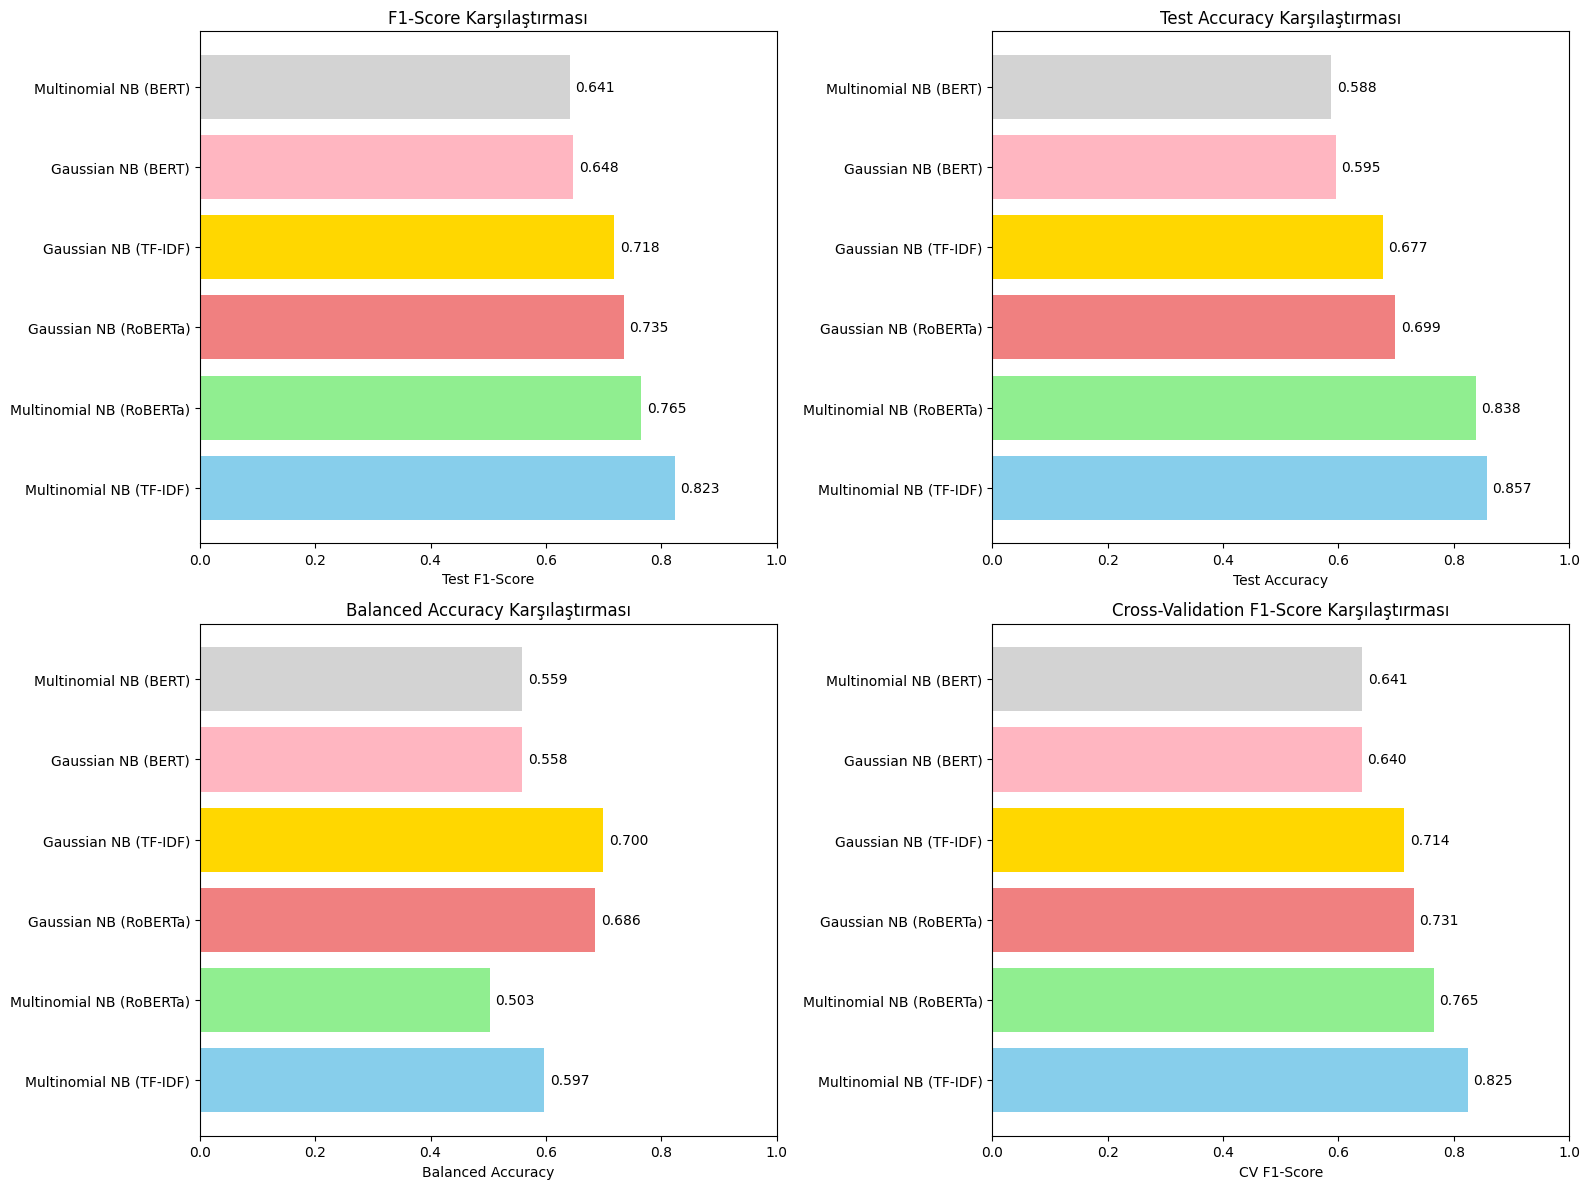

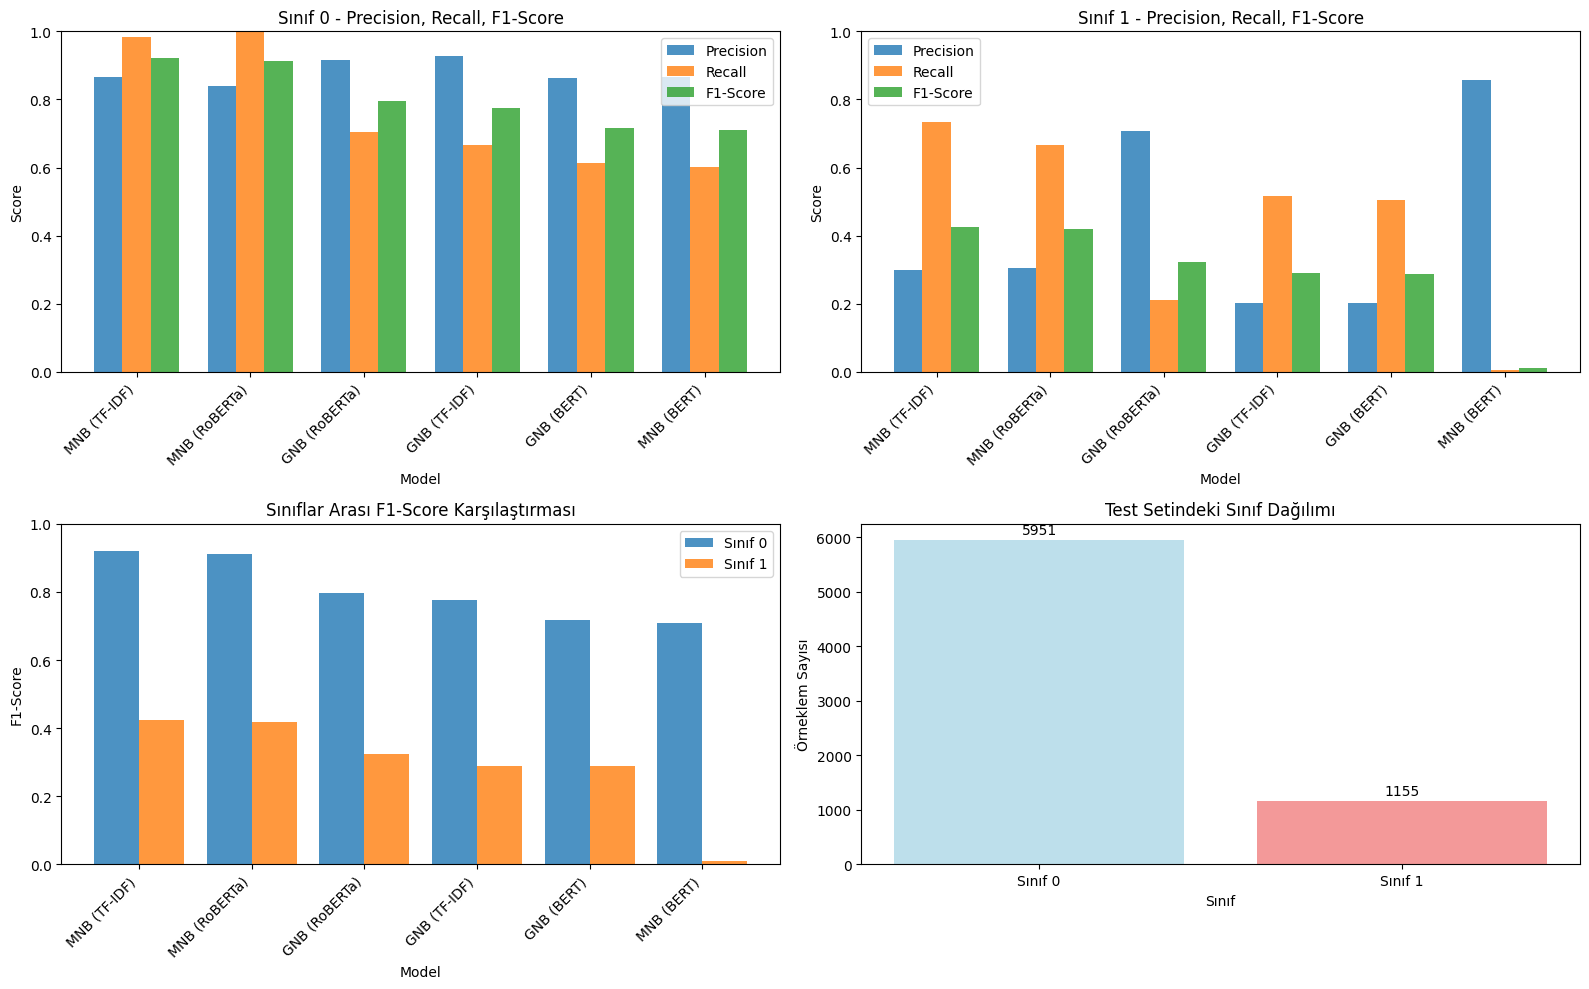

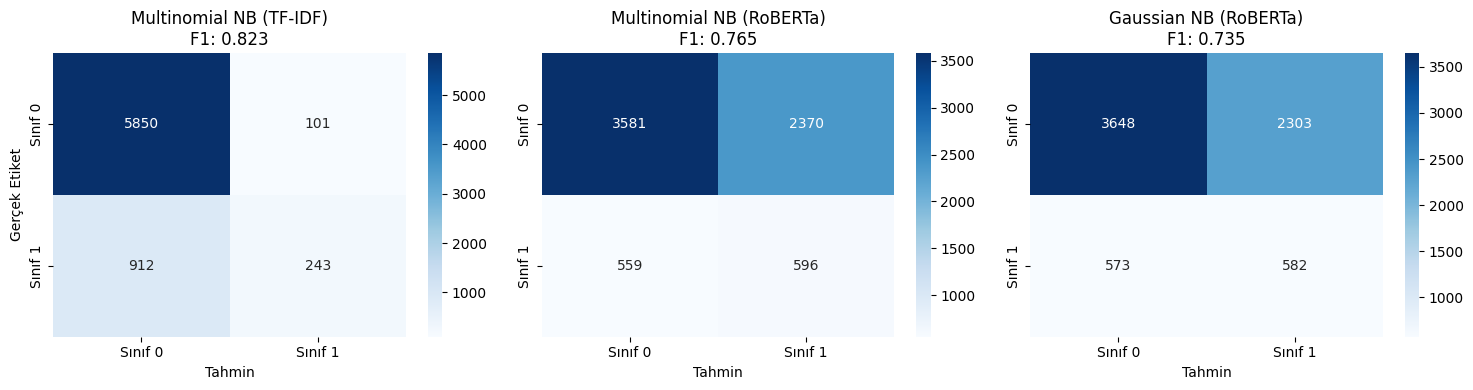


--- Embedding Yöntemleri Karşılaştırması ---
         Ortalama F1  En İyi F1
0                              
BERT          0.6445     0.6475
RoBERTa       0.7502     0.7653
TF-IDF        0.7709     0.8234

--- Naive Bayes Türleri Karşılaştırması ---
             Ortalama F1  En İyi F1
0                                  
Gaussian          0.7003     0.7351
Multinomial       0.7434     0.8234

11. MODELLERİ KAYDET
Tüm modeller kaydedildi: complete_naive_bayes_models_with_class_metrics.pkl

Örnek metin: İklim değişikliği konusundaki argümanlarını neden dinleyelim ki? Kendi evini bile temiz tutamıyor!...
------------------------------------------------------------
gaussian_nb_bert: Tahmin=1, Olasılık=1.000
gaussian_nb_roberta: Tahmin=0, Olasılık=1.000
gaussian_nb_tfidf: Tahmin=1, Olasılık=1.000
multinomial_nb_bert: Tahmin=1, Olasılık=1.000
multinomial_nb_roberta: Tahmin=0, Olasılık=0.893
multinomial_nb_tfidf: Tahmin=0, Olasılık=0.697

TÜM NAİVE BAYES MODELLERİ EĞİTİMİ TAMAMLANDI!

ÖZET:
-

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from transformers import AutoModel, AutoTokenizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import warnings
warnings.filterwarnings('ignore')

# Cihaz ayarları
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan cihaz: {device}")

# Veriyi yükle
df = pd.read_csv('dataset.csv')
metinler = df["text"].values.tolist()
labels = df["label"].values

# BERT Tokenizer ve model yükle
tokenizer_bert = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
bert_model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased").to(device)

# RoBERTa Tokenizer ve model yükle
tokenizer_roberta = AutoTokenizer.from_pretrained("TURKCELL/roberta-base-turkish-uncased")
roberta_model = AutoModel.from_pretrained("TURKCELL/roberta-base-turkish-uncased").to(device)

# BERT özellik çıkarım fonksiyonu
def extract_bert_features(texts, model, tokenizer, max_length=128, batch_size=32):
    """
    BERT modelinden özellik vektörleri çıkarır
    """
    model.eval()
    all_features = []

    for i in tqdm(range(0, len(texts), batch_size), desc="BERT özellik çıkarımı"):
        batch_texts = texts[i:i+batch_size]

        encoding = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.pooler_output.cpu().numpy()
            all_features.append(features)

    return np.vstack(all_features)

# RoBERTa özellik çıkarım fonksiyonu
def extract_roberta_features(texts, model, tokenizer, max_length=128, batch_size=32):
    """
    RoBERTa modelinden özellik vektörleri çıkarır
    """
    model.eval()
    all_features = []

    for i in tqdm(range(0, len(texts), batch_size), desc="RoBERTa özellik çıkarımı"):
        batch_texts = texts[i:i+batch_size]

        encoding = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # RoBERTa için last_hidden_state'in ortalamasını kullan
            features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_features.append(features)

    return np.vstack(all_features)

# Class-wise accuracy hesaplama fonksiyonu
def calculate_class_wise_metrics(y_true, y_pred):
    """Her sınıf için detaylı metrikler hesaplar"""
    cm = confusion_matrix(y_true, y_pred)
    class_metrics = {}

    for i in range(len(cm)):
        # True Positives, False Positives, False Negatives
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - tp - fp - fn

        # Metrikler
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        class_metrics[f'Sınıf {i}'] = {
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Specificity': specificity,
            'Support': cm[i, :].sum()
        }

    return class_metrics

# BERT özelliklerini çıkar
print("BERT özelliklerini çıkarıyor...")
bert_features = extract_bert_features(metinler, bert_model, tokenizer_bert)
print(f"BERT özellik boyutu: {bert_features.shape}")

# RoBERTa özelliklerini çıkar
print("RoBERTa özelliklerini çıkarıyor...")
roberta_features = extract_roberta_features(metinler, roberta_model, tokenizer_roberta)
print(f"RoBERTa özellik boyutu: {roberta_features.shape}")

# BERT için veriyi train/test olarak böl
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# RoBERTa için veriyi train/test olarak böl
X_train_roberta, X_test_roberta, y_train_roberta, y_test_roberta = train_test_split(
    roberta_features, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# Text için veriyi train/test olarak böl
metinler_train, metinler_test, y_train_text, y_test_text = train_test_split(
    metinler, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# TF-IDF vektörleştirici
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Unigram ve bigram
    stop_words=None,  # Türkçe stop words varsa ekleyebilirsiniz
    lowercase=True,
    max_df=0.95,  # Çok yaygın kelimeleri filtrele
    min_df=2      # Çok nadir kelimeleri filtrele
)

# TF-IDF özellikleri
X_train_tfidf = tfidf_vectorizer.fit_transform(metinler_train)
X_test_tfidf = tfidf_vectorizer.transform(metinler_test)

# TF-IDF'i dense matrix'e çevir (Gaussian NB için)
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

# Sınıf dağılımı kontrolü
from collections import Counter
class_counts = Counter(y_train_bert)
print(f"Sınıf dağılımı: {class_counts}")

print("\n" + "="*80)
print("NAİVE BAYES MODELLERİ EĞİTİMİ - TÜM KOMBİNASYONLAR")
print("="*80)

# ============================================================================
# 1. GAUSSIAN NAIVE BAYES (BERT ÖZELLİKLERİ)
# ============================================================================
print("\n" + "="*60)
print("1. GAUSSIAN NAIVE BAYES (BERT ÖZELLİKLERİ)")
print("="*60)

# Gaussian NB için BERT özelliklerini standartlaştır
scaler_gaussian_bert = StandardScaler()
X_train_gaussian_bert = scaler_gaussian_bert.fit_transform(X_train_bert)
X_test_gaussian_bert = scaler_gaussian_bert.transform(X_test_bert)

# Gaussian NB modeli (BERT)
gnb_bert = GaussianNB(priors=None, var_smoothing=1e-9)
gnb_bert.fit(X_train_gaussian_bert, y_train_bert)

# Tahminler
y_pred_test_gnb_bert = gnb_bert.predict(X_test_gaussian_bert)
y_proba_test_gnb_bert = gnb_bert.predict_proba(X_test_gaussian_bert)

# Performans metrikleri
test_acc_gnb_bert = accuracy_score(y_test_bert, y_pred_test_gnb_bert)
test_f1_gnb_bert = f1_score(y_test_bert, y_pred_test_gnb_bert, average='weighted')
balanced_acc_gnb_bert = balanced_accuracy_score(y_test_bert, y_pred_test_gnb_bert)
cv_scores_gnb_bert = cross_val_score(gnb_bert, X_train_gaussian_bert, y_train_bert, cv=5, scoring='f1_weighted')

# Class-wise metrics
gnb_bert_class_metrics = calculate_class_wise_metrics(y_test_bert, y_pred_test_gnb_bert)

print(f"Gaussian NB (BERT) Test Doğruluğu: {test_acc_gnb_bert:.4f}")
print(f"Gaussian NB (BERT) Balanced Doğruluğu: {balanced_acc_gnb_bert:.4f}")
print(f"Gaussian NB (BERT) Test F1: {test_f1_gnb_bert:.4f}")
print(f"Gaussian NB (BERT) CV F1: {cv_scores_gnb_bert.mean():.4f} (+/- {cv_scores_gnb_bert.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in gnb_bert_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 2. GAUSSIAN NAIVE BAYES (ROBERTA ÖZELLİKLERİ)
# ============================================================================
print("\n" + "="*60)
print("2. GAUSSIAN NAIVE BAYES (ROBERTA ÖZELLİKLERİ)")
print("="*60)

# Gaussian NB için RoBERTa özelliklerini standartlaştır
scaler_gaussian_roberta = StandardScaler()
X_train_gaussian_roberta = scaler_gaussian_roberta.fit_transform(X_train_roberta)
X_test_gaussian_roberta = scaler_gaussian_roberta.transform(X_test_roberta)

# Gaussian NB modeli (RoBERTa)
gnb_roberta = GaussianNB(priors=None, var_smoothing=1e-9)
gnb_roberta.fit(X_train_gaussian_roberta, y_train_roberta)

# Tahminler
y_pred_test_gnb_roberta = gnb_roberta.predict(X_test_gaussian_roberta)
y_proba_test_gnb_roberta = gnb_roberta.predict_proba(X_test_gaussian_roberta)

# Performans metrikleri
test_acc_gnb_roberta = accuracy_score(y_test_roberta, y_pred_test_gnb_roberta)
test_f1_gnb_roberta = f1_score(y_test_roberta, y_pred_test_gnb_roberta, average='weighted')
balanced_acc_gnb_roberta = balanced_accuracy_score(y_test_roberta, y_pred_test_gnb_roberta)
cv_scores_gnb_roberta = cross_val_score(gnb_roberta, X_train_gaussian_roberta, y_train_roberta, cv=5, scoring='f1_weighted')

# Class-wise metrics
gnb_roberta_class_metrics = calculate_class_wise_metrics(y_test_roberta, y_pred_test_gnb_roberta)

print(f"Gaussian NB (RoBERTa) Test Doğruluğu: {test_acc_gnb_roberta:.4f}")
print(f"Gaussian NB (RoBERTa) Balanced Doğruluğu: {balanced_acc_gnb_roberta:.4f}")
print(f"Gaussian NB (RoBERTa) Test F1: {test_f1_gnb_roberta:.4f}")
print(f"Gaussian NB (RoBERTa) CV F1: {cv_scores_gnb_roberta.mean():.4f} (+/- {cv_scores_gnb_roberta.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in gnb_roberta_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 3. GAUSSIAN NAIVE BAYES (TF-IDF ÖZELLİKLERİ)
# ============================================================================
print("\n" + "="*60)
print("3. GAUSSIAN NAIVE BAYES (TF-IDF ÖZELLİKLERİ)")
print("="*60)

# Gaussian NB için TF-IDF özelliklerini standartlaştır
scaler_gaussian_tfidf = StandardScaler()
X_train_gaussian_tfidf = scaler_gaussian_tfidf.fit_transform(X_train_tfidf_dense)
X_test_gaussian_tfidf = scaler_gaussian_tfidf.transform(X_test_tfidf_dense)

# Gaussian NB modeli (TF-IDF)
gnb_tfidf = GaussianNB(priors=None, var_smoothing=1e-9)
gnb_tfidf.fit(X_train_gaussian_tfidf, y_train_text)

# Tahminler
y_pred_test_gnb_tfidf = gnb_tfidf.predict(X_test_gaussian_tfidf)
y_proba_test_gnb_tfidf = gnb_tfidf.predict_proba(X_test_gaussian_tfidf)

# Performans metrikleri
test_acc_gnb_tfidf = accuracy_score(y_test_text, y_pred_test_gnb_tfidf)
test_f1_gnb_tfidf = f1_score(y_test_text, y_pred_test_gnb_tfidf, average='weighted')
balanced_acc_gnb_tfidf = balanced_accuracy_score(y_test_text, y_pred_test_gnb_tfidf)
cv_scores_gnb_tfidf = cross_val_score(gnb_tfidf, X_train_gaussian_tfidf, y_train_text, cv=5, scoring='f1_weighted')

# Class-wise metrics
gnb_tfidf_class_metrics = calculate_class_wise_metrics(y_test_text, y_pred_test_gnb_tfidf)

print(f"Gaussian NB (TF-IDF) Test Doğruluğu: {test_acc_gnb_tfidf:.4f}")
print(f"Gaussian NB (TF-IDF) Balanced Doğruluğu: {balanced_acc_gnb_tfidf:.4f}")
print(f"Gaussian NB (TF-IDF) Test F1: {test_f1_gnb_tfidf:.4f}")
print(f"Gaussian NB (TF-IDF) CV F1: {cv_scores_gnb_tfidf.mean():.4f} (+/- {cv_scores_gnb_tfidf.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in gnb_tfidf_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 4. MULTINOMIAL NAIVE BAYES (BERT ÖZELLİKLERİ)
# ============================================================================
print("\n" + "="*60)
print("4. MULTINOMIAL NAIVE BAYES (BERT ÖZELLİKLERİ)")
print("="*60)

# Multinomial NB için BERT özelliklerini pozitif hale getir
scaler_multinomial_bert = MinMaxScaler()
X_train_multinomial_bert = scaler_multinomial_bert.fit_transform(X_train_bert) + 1e-6
X_test_multinomial_bert = scaler_multinomial_bert.transform(X_test_bert) + 1e-6

# Multinomial NB modeli (BERT)
mnb_bert = MultinomialNB(alpha=1.0, fit_prior=True)
mnb_bert.fit(X_train_multinomial_bert, y_train_bert)

# Tahminler
y_pred_test_mnb_bert = mnb_bert.predict(X_test_multinomial_bert)
y_proba_test_mnb_bert = mnb_bert.predict_proba(X_test_multinomial_bert)

# Performans metrikleri
test_acc_mnb_bert = accuracy_score(y_test_bert, y_pred_test_mnb_bert)
test_f1_mnb_bert = f1_score(y_test_bert, y_pred_test_mnb_bert, average='weighted')
balanced_acc_mnb_bert = balanced_accuracy_score(y_test_bert, y_pred_test_mnb_bert)
cv_scores_mnb_bert = cross_val_score(mnb_bert, X_train_multinomial_bert, y_train_bert, cv=5, scoring='f1_weighted')

# Class-wise metrics
mnb_bert_class_metrics = calculate_class_wise_metrics(y_test_bert, y_pred_test_mnb_bert)

print(f"Multinomial NB (BERT) Test Doğruluğu: {test_acc_mnb_bert:.4f}")
print(f"Multinomial NB (BERT) Balanced Doğruluğu: {balanced_acc_mnb_bert:.4f}")
print(f"Multinomial NB (BERT) Test F1: {test_f1_mnb_bert:.4f}")
print(f"Multinomial NB (BERT) CV F1: {cv_scores_mnb_bert.mean():.4f} (+/- {cv_scores_mnb_bert.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in mnb_bert_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 5. MULTINOMIAL NAIVE BAYES (ROBERTA ÖZELLİKLERİ)
# ============================================================================
print("\n" + "="*60)
print("5. MULTINOMIAL NAIVE BAYES (ROBERTA ÖZELLİKLERİ)")
print("="*60)

# Multinomial NB için RoBERTa özelliklerini pozitif hale getir
scaler_multinomial_roberta = MinMaxScaler()
X_train_multinomial_roberta = scaler_multinomial_roberta.fit_transform(X_train_roberta) + 1e-6
X_test_multinomial_roberta = scaler_multinomial_roberta.transform(X_test_roberta) + 1e-6

# Multinomial NB modeli (RoBERTa)
mnb_roberta = MultinomialNB(alpha=1.0, fit_prior=True)
mnb_roberta.fit(X_train_multinomial_roberta, y_train_roberta)

# Tahminler
y_pred_test_mnb_roberta = mnb_roberta.predict(X_test_multinomial_roberta)
y_proba_test_mnb_roberta = mnb_roberta.predict_proba(X_test_multinomial_roberta)

# Performans metrikleri
test_acc_mnb_roberta = accuracy_score(y_test_roberta, y_pred_test_mnb_roberta)
test_f1_mnb_roberta = f1_score(y_test_roberta, y_pred_test_mnb_roberta, average='weighted')
balanced_acc_mnb_roberta = balanced_accuracy_score(y_test_roberta, y_pred_test_mnb_roberta)
cv_scores_mnb_roberta = cross_val_score(mnb_roberta, X_train_multinomial_roberta, y_train_roberta, cv=5, scoring='f1_weighted')

# Class-wise metrics
mnb_roberta_class_metrics = calculate_class_wise_metrics(y_test_roberta, y_pred_test_mnb_roberta)

print(f"Multinomial NB (RoBERTa) Test Doğruluğu: {test_acc_mnb_roberta:.4f}")
print(f"Multinomial NB (RoBERTa) Balanced Doğruluğu: {balanced_acc_mnb_roberta:.4f}")
print(f"Multinomial NB (RoBERTa) Test F1: {test_f1_mnb_roberta:.4f}")
print(f"Multinomial NB (RoBERTa) CV F1: {cv_scores_mnb_roberta.mean():.4f} (+/- {cv_scores_mnb_roberta.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in mnb_roberta_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 6. MULTINOMIAL NAIVE BAYES (TF-IDF ÖZELLİKLERİ)
# ============================================================================
print("\n" + "="*60)
print("6. MULTINOMIAL NAIVE BAYES (TF-IDF ÖZELLİKLERİ)")
print("="*60)

# Multinomial NB modeli (TF-IDF) - direkt sparse matrix kullanabilir
mnb_tfidf = MultinomialNB(alpha=1.0, fit_prior=True)
mnb_tfidf.fit(X_train_tfidf, y_train_text)

# Tahminler
y_pred_test_mnb_tfidf = mnb_tfidf.predict(X_test_tfidf)
y_proba_test_mnb_tfidf = mnb_tfidf.predict_proba(X_test_tfidf)

# Performans metrikleri
test_acc_mnb_tfidf = accuracy_score(y_test_text, y_pred_test_mnb_tfidf)
test_f1_mnb_tfidf = f1_score(y_test_text, y_pred_test_mnb_tfidf, average='weighted')
balanced_acc_mnb_tfidf = balanced_accuracy_score(y_test_text, y_pred_test_mnb_tfidf)
cv_scores_mnb_tfidf = cross_val_score(mnb_tfidf, X_train_tfidf, y_train_text, cv=5, scoring='f1_weighted')

# Class-wise metrics
mnb_tfidf_class_metrics = calculate_class_wise_metrics(y_test_text, y_pred_test_mnb_tfidf)

print(f"Multinomial NB (TF-IDF) Test Doğruluğu: {test_acc_mnb_tfidf:.4f}")
print(f"Multinomial NB (TF-IDF) Balanced Doğruluğu: {balanced_acc_mnb_tfidf:.4f}")
print(f"Multinomial NB (TF-IDF) Test F1: {test_f1_mnb_tfidf:.4f}")
print(f"Multinomial NB (TF-IDF) CV F1: {cv_scores_mnb_tfidf.mean():.4f} (+/- {cv_scores_mnb_tfidf.std() * 2:.4f})")

print("\n--- Sınıf Bazlı Metrikler ---")
for class_name, metrics in mnb_tfidf_class_metrics.items():
    print(f"{class_name}: Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1={metrics['F1-Score']:.4f}, Specificity={metrics['Specificity']:.4f}")

# ============================================================================
# 7. MODEL KARŞILAŞTIRMASI
# ============================================================================
print("\n" + "="*60)
print("7. TÜM MODEL KARŞILAŞTIRMASI")
print("="*60)

# Model karşılaştırma tablosu (genişletilmiş)
comparison_data = {
    'Model': [
        'Gaussian NB (BERT)',
        'Gaussian NB (RoBERTa)',
        'Gaussian NB (TF-IDF)',
        'Multinomial NB (BERT)',
        'Multinomial NB (RoBERTa)',
        'Multinomial NB (TF-IDF)'
    ],
    'Test Accuracy': [
        test_acc_gnb_bert,
        test_acc_gnb_roberta,
        test_acc_gnb_tfidf,
        test_acc_mnb_bert,
        test_acc_mnb_roberta,
        test_acc_mnb_tfidf
    ],
    'Balanced Accuracy': [
        balanced_acc_gnb_bert,
        balanced_acc_gnb_roberta,
        balanced_acc_gnb_tfidf,
        balanced_acc_mnb_bert,
        balanced_acc_mnb_roberta,
        balanced_acc_mnb_tfidf
    ],
    'Test F1-Score': [
        test_f1_gnb_bert,
        test_f1_gnb_roberta,
        test_f1_gnb_tfidf,
        test_f1_mnb_bert,
        test_f1_mnb_roberta,
        test_f1_mnb_tfidf
    ],
    'CV F1-Score': [
        cv_scores_gnb_bert.mean(),
        cv_scores_gnb_roberta.mean(),
        cv_scores_gnb_tfidf.mean(),
        cv_scores_mnb_bert.mean(),
        cv_scores_mnb_roberta.mean(),
        cv_scores_mnb_tfidf.mean()
    ]
}

comparison_df = pd.DataFrame(comparison_data)
# F1-Score'a göre sırala
comparison_df = comparison_df.sort_values('Test F1-Score', ascending=False)
print(comparison_df.round(4))

# En iyi modeli belirle
best_idx = comparison_df.index[0]
best_model_name = comparison_df.loc[best_idx, 'Model']
best_f1 = comparison_df.loc[best_idx, 'Test F1-Score']
print(f"\nEn iyi model: {best_model_name}")
print(f"En iyi F1-Score: {best_f1:.4f}")

# ============================================================================
# 8. SINIF BAZLI METRİKLER KARŞILAŞTIRMASI
# ============================================================================
print("\n" + "="*60)
print("8. SINIF BAZLI METRİKLER KARŞILAŞTIRMASI")
print("="*60)

# Tüm modellerin class-wise metriklerini topla
all_class_metrics = {
    'Gaussian NB (BERT)': gnb_bert_class_metrics,
    'Gaussian NB (RoBERTa)': gnb_roberta_class_metrics,
    'Gaussian NB (TF-IDF)': gnb_tfidf_class_metrics,
    'Multinomial NB (BERT)': mnb_bert_class_metrics,
    'Multinomial NB (RoBERTa)': mnb_roberta_class_metrics,
    'Multinomial NB (TF-IDF)': mnb_tfidf_class_metrics
}

# Sınıf bazlı karşılaştırma tablosu oluştur
class_comparison_data = []
for model_name, class_metrics in all_class_metrics.items():
    for class_name, metrics in class_metrics.items():
        class_comparison_data.append({
            'Model': model_name,
            'Class': class_name,
            'Precision': metrics['Precision'],
            'Recall': metrics['Recall'],
            'F1-Score': metrics['F1-Score'],
            'Specificity': metrics['Specificity'],
            'Support': metrics['Support']
        })

class_comparison_df = pd.DataFrame(class_comparison_data)

# Sınıf 0 ve Sınıf 1 için ayrı ayrı göster
print("\n--- SINIF 0 METRİKLERİ ---")
class_0_df = class_comparison_df[class_comparison_df['Class'] == 'Sınıf 0'].sort_values('F1-Score', ascending=False)
print(class_0_df[['Model', 'Precision', 'Recall', 'F1-Score', 'Specificity']].round(4))

print("\n--- SINIF 1 METRİKLERİ ---")
class_1_df = class_comparison_df[class_comparison_df['Class'] == 'Sınıf 1'].sort_values('F1-Score', ascending=False)
print(class_1_df[['Model', 'Precision', 'Recall', 'F1-Score', 'Specificity']].round(4))

# ============================================================================
# 9. DETAYLI DEĞERLENDİRME
# ============================================================================
print("\n" + "="*60)
print("9. TOP 3 MODEL DETAYLI DEĞERLENDİRME")
print("="*60)

# Top 3 model için detaylı raporlar
top_3_models = comparison_df.head(3)

for idx, row in top_3_models.iterrows():
    model_name = row['Model']
    print(f"\n--- {model_name} ---")

    if 'BERT' in model_name:
        if 'Gaussian' in model_name:
            print(classification_report(y_test_bert, y_pred_test_gnb_bert))
        else:
            print(classification_report(y_test_bert, y_pred_test_mnb_bert))
    elif 'RoBERTa' in model_name:
        if 'Gaussian' in model_name:
            print(classification_report(y_test_roberta, y_pred_test_gnb_roberta))
        else:
            print(classification_report(y_test_roberta, y_pred_test_mnb_roberta))
    elif 'TF-IDF' in model_name:
        if 'Gaussian' in model_name:
            print(classification_report(y_test_text, y_pred_test_gnb_tfidf))
        else:
            print(classification_report(y_test_text, y_pred_test_mnb_tfidf))

# ============================================================================
# 10. GÖRSELLEŞTİRMELER
# ============================================================================
print("\n" + "="*60)
print("10. GÖRSELLEŞTİRMELER")
print("="*60)

# Model karşılaştırma bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# F1-Score karşılaştırması
model_names = comparison_df['Model'].values
f1_scores = comparison_df['Test F1-Score'].values
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'lightpink', 'lightgray']

bars = axes[0, 0].barh(model_names, f1_scores, color=colors[:len(model_names)])
axes[0, 0].set_xlabel('Test F1-Score')
axes[0, 0].set_title('F1-Score Karşılaştırması')
axes[0, 0].set_xlim(0, 1)

# Value labels ekle
for i, v in enumerate(f1_scores):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Accuracy karşılaştırması
accuracies = comparison_df['Test Accuracy'].values
bars = axes[0, 1].barh(model_names, accuracies, color=colors[:len(model_names)])
axes[0, 1].set_xlabel('Test Accuracy')
axes[0, 1].set_title('Test Accuracy Karşılaştırması')
axes[0, 1].set_xlim(0, 1)

# Value labels ekle
for i, v in enumerate(accuracies):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# Balanced Accuracy karşılaştırması
balanced_accuracies = comparison_df['Balanced Accuracy'].values
bars = axes[1, 0].barh(model_names, balanced_accuracies, color=colors[:len(model_names)])
axes[1, 0].set_xlabel('Balanced Accuracy')
axes[1, 0].set_title('Balanced Accuracy Karşılaştırması')
axes[1, 0].set_xlim(0, 1)

# Value labels ekle
for i, v in enumerate(balanced_accuracies):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# CV F1-Score karşılaştırması
cv_f1_scores = comparison_df['CV F1-Score'].values
bars = axes[1, 1].barh(model_names, cv_f1_scores, color=colors[:len(model_names)])
axes[1, 1].set_xlabel('CV F1-Score')
axes[1, 1].set_title('Cross-Validation F1-Score Karşılaştırması')
axes[1, 1].set_xlim(0, 1)

# Value labels ekle
for i, v in enumerate(cv_f1_scores):
    axes[1, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Sınıf bazlı metrikler görselleştirmesi
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Sınıf 0 için metrikler
class_0_precision = class_0_df['Precision'].values
class_0_recall = class_0_df['Recall'].values
class_0_f1 = class_0_df['F1-Score'].values
model_names_short = [name.replace('Gaussian NB', 'GNB').replace('Multinomial NB', 'MNB') for name in class_0_df['Model'].values]

x = np.arange(len(model_names_short))
width = 0.25

axes[0, 0].bar(x - width, class_0_precision, width, label='Precision', alpha=0.8)
axes[0, 0].bar(x, class_0_recall, width, label='Recall', alpha=0.8)
axes[0, 0].bar(x + width, class_0_f1, width, label='F1-Score', alpha=0.8)
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Sınıf 0 - Precision, Recall, F1-Score')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names_short, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 1)

# Sınıf 1 için metrikler
class_1_precision = class_1_df['Precision'].values
class_1_recall = class_1_df['Recall'].values
class_1_f1 = class_1_df['F1-Score'].values

axes[0, 1].bar(x - width, class_1_precision, width, label='Precision', alpha=0.8)
axes[0, 1].bar(x, class_1_recall, width, label='Recall', alpha=0.8)
axes[0, 1].bar(x + width, class_1_f1, width, label='F1-Score', alpha=0.8)
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Sınıf 1 - Precision, Recall, F1-Score')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(model_names_short, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1)

# Sınıflar arası F1-Score karşılaştırması
class_0_models = class_0_df['Model'].values
class_1_models = class_1_df['Model'].values

x_pos = np.arange(len(class_0_models))
axes[1, 0].bar(x_pos - 0.2, class_0_df['F1-Score'].values, 0.4, label='Sınıf 0', alpha=0.8)
axes[1, 0].bar(x_pos + 0.2, class_1_df['F1-Score'].values, 0.4, label='Sınıf 1', alpha=0.8)
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_title('Sınıflar Arası F1-Score Karşılaştırması')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([name.replace('Gaussian NB', 'GNB').replace('Multinomial NB', 'MNB') for name in class_0_models], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)

# Support (örneklem sayısı) bilgisi
support_data = []
for class_name in ['Sınıf 0', 'Sınıf 1']:
    class_data = class_comparison_df[class_comparison_df['Class'] == class_name]
    support_data.append(class_data['Support'].iloc[0])  # Tüm modeller için aynı olacak

axes[1, 1].bar(['Sınıf 0', 'Sınıf 1'], support_data, color=['lightblue', 'lightcoral'], alpha=0.8)
axes[1, 1].set_xlabel('Sınıf')
axes[1, 1].set_ylabel('Örneklem Sayısı')
axes[1, 1].set_title('Test Setindeki Sınıf Dağılımı')

# Value labels ekle
for i, v in enumerate(support_data):
    axes[1, 1].text(i, v + max(support_data) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Top 3 modeller için confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (_, row) in enumerate(top_3_models.iterrows()):
    model_name = row['Model']

    if 'BERT' in model_name:
        if 'Gaussian' in model_name:
            y_pred = y_pred_test_gnb_bert
            y_true = y_test_bert
        else:
            y_pred = y_pred_test_mnb_bert
            y_true = y_test_bert
    elif 'RoBERTa' in model_name:
        if 'Gaussian' in model_name:
            y_pred = y_pred_test_gnb_roberta
            y_true = y_test_roberta
        else:
            y_pred = y_pred_test_mnb_roberta
            y_true = y_test_roberta
    elif 'TF-IDF' in model_name:
        if 'Gaussian' in model_name:
            y_pred = y_pred_test_gnb_tfidf
            y_true = y_test_text
        else:
            y_pred = y_pred_test_mnb_tfidf
            y_true = y_test_text

    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Sınıf 0', 'Sınıf 1'],
                yticklabels=['Sınıf 0', 'Sınıf 1'])
    axes[idx].set_title(f'{model_name}\nF1: {row["Test F1-Score"]:.3f}')
    axes[idx].set_xlabel('Tahmin')
    if idx == 0:
        axes[idx].set_ylabel('Gerçek Etiket')

plt.tight_layout()
plt.show()

# Embedding yöntemi karşılaştırması
embedding_comparison = comparison_df.groupby(comparison_df['Model'].str.extract(r'\((.*?)\)')[0])['Test F1-Score'].agg(['mean', 'max']).round(4)
embedding_comparison.columns = ['Ortalama F1', 'En İyi F1']

print("\n--- Embedding Yöntemleri Karşılaştırması ---")
print(embedding_comparison)

# NB türü karşılaştırması
nb_comparison = comparison_df.groupby(comparison_df['Model'].str.extract(r'(.*?) NB')[0])['Test F1-Score'].agg(['mean', 'max']).round(4)
nb_comparison.columns = ['Ortalama F1', 'En İyi F1']

print("\n--- Naive Bayes Türleri Karşılaştırması ---")
print(nb_comparison)

# ============================================================================
# 11. MODELLERİ KAYDET
# ============================================================================
print("\n" + "="*60)
print("11. MODELLERİ KAYDET")
print("="*60)

# Tüm modelleri kaydet
models_package = {
    'gaussian_nb_bert': {
        'model': gnb_bert,
        'scaler': scaler_gaussian_bert,
        'tokenizer': tokenizer_bert,
        'bert_model': bert_model
    },
    'gaussian_nb_roberta': {
        'model': gnb_roberta,
        'scaler': scaler_gaussian_roberta,
        'tokenizer': tokenizer_roberta,
        'roberta_model': roberta_model
    },
    'gaussian_nb_tfidf': {
        'model': gnb_tfidf,
        'scaler': scaler_gaussian_tfidf,
        'vectorizer': tfidf_vectorizer
    },
    'multinomial_nb_bert': {
        'model': mnb_bert,
        'scaler': scaler_multinomial_bert,
        'tokenizer': tokenizer_bert,
        'bert_model': bert_model
    },
    'multinomial_nb_roberta': {
        'model': mnb_roberta,
        'scaler': scaler_multinomial_roberta,
        'tokenizer': tokenizer_roberta,
        'roberta_model': roberta_model
    },
    'multinomial_nb_tfidf': {
        'model': mnb_tfidf,
        'vectorizer': tfidf_vectorizer
    },
    'comparison_results': comparison_df,
    'class_wise_metrics': all_class_metrics
}

joblib.dump(models_package, 'complete_naive_bayes_models_with_class_metrics.pkl')
print("Tüm modeller kaydedildi: complete_naive_bayes_models_with_class_metrics.pkl")

# ============================================================================
# 12. TAHMİN FONKSİYONLARI
# ============================================================================

def predict_with_model(text, model_name, models_dict):
    """Herhangi bir model ile tahmin yap"""

    if model_name == 'gaussian_nb_bert':
        model_dict = models_dict[model_name]
        encoding = model_dict['tokenizer']([text], padding=True, truncation=True,
                                          max_length=128, return_tensors='pt')

        model_dict['bert_model'].eval()
        with torch.no_grad():
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model_dict['bert_model'](input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.pooler_output.cpu().numpy()

        features_scaled = model_dict['scaler'].transform(features)
        prediction = model_dict['model'].predict(features_scaled)[0]
        probability = model_dict['model'].predict_proba(features_scaled)[0]

    elif model_name == 'gaussian_nb_roberta':
        model_dict = models_dict[model_name]
        encoding = model_dict['tokenizer']([text], padding=True, truncation=True,
                                          max_length=128, return_tensors='pt')

        model_dict['roberta_model'].eval()
        with torch.no_grad():
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model_dict['roberta_model'](input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        features_scaled = model_dict['scaler'].transform(features)
        prediction = model_dict['model'].predict(features_scaled)[0]
        probability = model_dict['model'].predict_proba(features_scaled)[0]

    elif model_name == 'gaussian_nb_tfidf':
        model_dict = models_dict[model_name]
        features = model_dict['vectorizer'].transform([text]).toarray()
        features_scaled = model_dict['scaler'].transform(features)
        prediction = model_dict['model'].predict(features_scaled)[0]
        probability = model_dict['model'].predict_proba(features_scaled)[0]

    elif model_name == 'multinomial_nb_bert':
        model_dict = models_dict[model_name]
        encoding = model_dict['tokenizer']([text], padding=True, truncation=True,
                                          max_length=128, return_tensors='pt')

        model_dict['bert_model'].eval()
        with torch.no_grad():
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model_dict['bert_model'](input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.pooler_output.cpu().numpy()

        features_scaled = model_dict['scaler'].transform(features) + 1e-6
        prediction = model_dict['model'].predict(features_scaled)[0]
        probability = model_dict['model'].predict_proba(features_scaled)[0]

    elif model_name == 'multinomial_nb_roberta':
        model_dict = models_dict[model_name]
        encoding = model_dict['tokenizer']([text], padding=True, truncation=True,
                                          max_length=128, return_tensors='pt')

        model_dict['roberta_model'].eval()
        with torch.no_grad():
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            outputs = model_dict['roberta_model'](input_ids=input_ids, attention_mask=attention_mask)
            features = outputs.last_hidden_state.mean(dim=1).cpu().numpy()

        features_scaled = model_dict['scaler'].transform(features) + 1e-6
        prediction = model_dict['model'].predict(features_scaled)[0]
        probability = model_dict['model'].predict_proba(features_scaled)[0]

    elif model_name == 'multinomial_nb_tfidf':
        model_dict = models_dict[model_name]
        features = model_dict['vectorizer'].transform([text])
        prediction = model_dict['model'].predict(features)[0]
        probability = model_dict['model'].predict_proba(features)[0]

    else:
        return None, None

    return prediction, probability

# Örnek tahminler
if len(metinler) > 0:
    sample_text = metinler[0]
    print(f"\nÖrnek metin: {sample_text[:100]}...")
    print("-" * 60)

    # Tüm modellerle tahmin yap
    for model_name in models_package.keys():
        if model_name not in ['comparison_results', 'class_wise_metrics']:
            pred, prob = predict_with_model(sample_text, model_name, models_package)
            if pred is not None:
                print(f"{model_name}: Tahmin={pred}, Olasılık={prob[pred]:.3f}")

print("\n" + "="*80)
print("TÜM NAİVE BAYES MODELLERİ EĞİTİMİ TAMAMLANDI!")
print("="*80)

# Final özet
print(f"\nÖZET:")
print(f"- Toplam 6 model kombinasyonu eğitildi")
print(f"- En iyi model: {best_model_name} (F1: {best_f1:.4f})")
print(f"- Tüm modeller 'complete_naive_bayes_models_with_class_metrics.pkl' dosyasına kaydedildi")
print(f"- En iyi embedding yöntemi: {embedding_comparison.index[embedding_comparison['En İyi F1'].idxmax()]}")
print(f"- En iyi NB türü: {nb_comparison.index[nb_comparison['En İyi F1'].idxmax()]}")

# Class-wise performance özeti
print(f"\n--- SINIF BAZLI ÖZET ---")
print(f"Sınıf 0 en iyi F1: {class_0_df['F1-Score'].max():.4f} ({class_0_df.iloc[0]['Model']})")
print(f"Sınıf 1 en iyi F1: {class_1_df['F1-Score'].max():.4f} ({class_1_df.iloc[0]['Model']})")

# Balanced accuracy bilgisi
print(f"\n--- DENGELI DOĞRULUK ---")
print(f"En yüksek Balanced Accuracy: {comparison_df['Balanced Accuracy'].max():.4f}")
balanced_best_model = comparison_df.loc[comparison_df['Balanced Accuracy'].idxmax(), 'Model']
print(f"Balanced Accuracy en iyi model: {balanced_best_model}")

Starting Naive Bayes training with FastText and Word2Vec embeddings...
Starting Naive Bayes experiments with FastText and Word2Vec embeddings...
Dataset loaded successfully
Total samples: 35530
Label distribution: Counter({0: 29755, 1: 5775})
Vocabulary size: 60179
Processed 35530 texts

Processing FASTTEXT embeddings
Loading embeddings from embedded_fasttext.npy
Embeddings shape: (35225, 100)

----------------------------------------
Processing with MEAN aggregation...
----------------------------------------
Feature shape: (28424, 100)
Feature range: [-3.510, 3.804]

--------------------------------------------------
Training fasttext_mean_gaussian_nb
Training samples: 28424
Test samples: 7106
Feature dimensions: 100
--------------------------------------------------
Training Gaussian Naive Bayes...

TRAINING RESULTS:

Training Metrics:
Accuracy: 0.4363
F1 Score (Weighted): 0.4990
F1 Score (Macro): 0.4013
F1 Score Class 0: 0.5460
F1 Score Class 1: 0.2567
Confusion Matrix:
[[ 9634 141

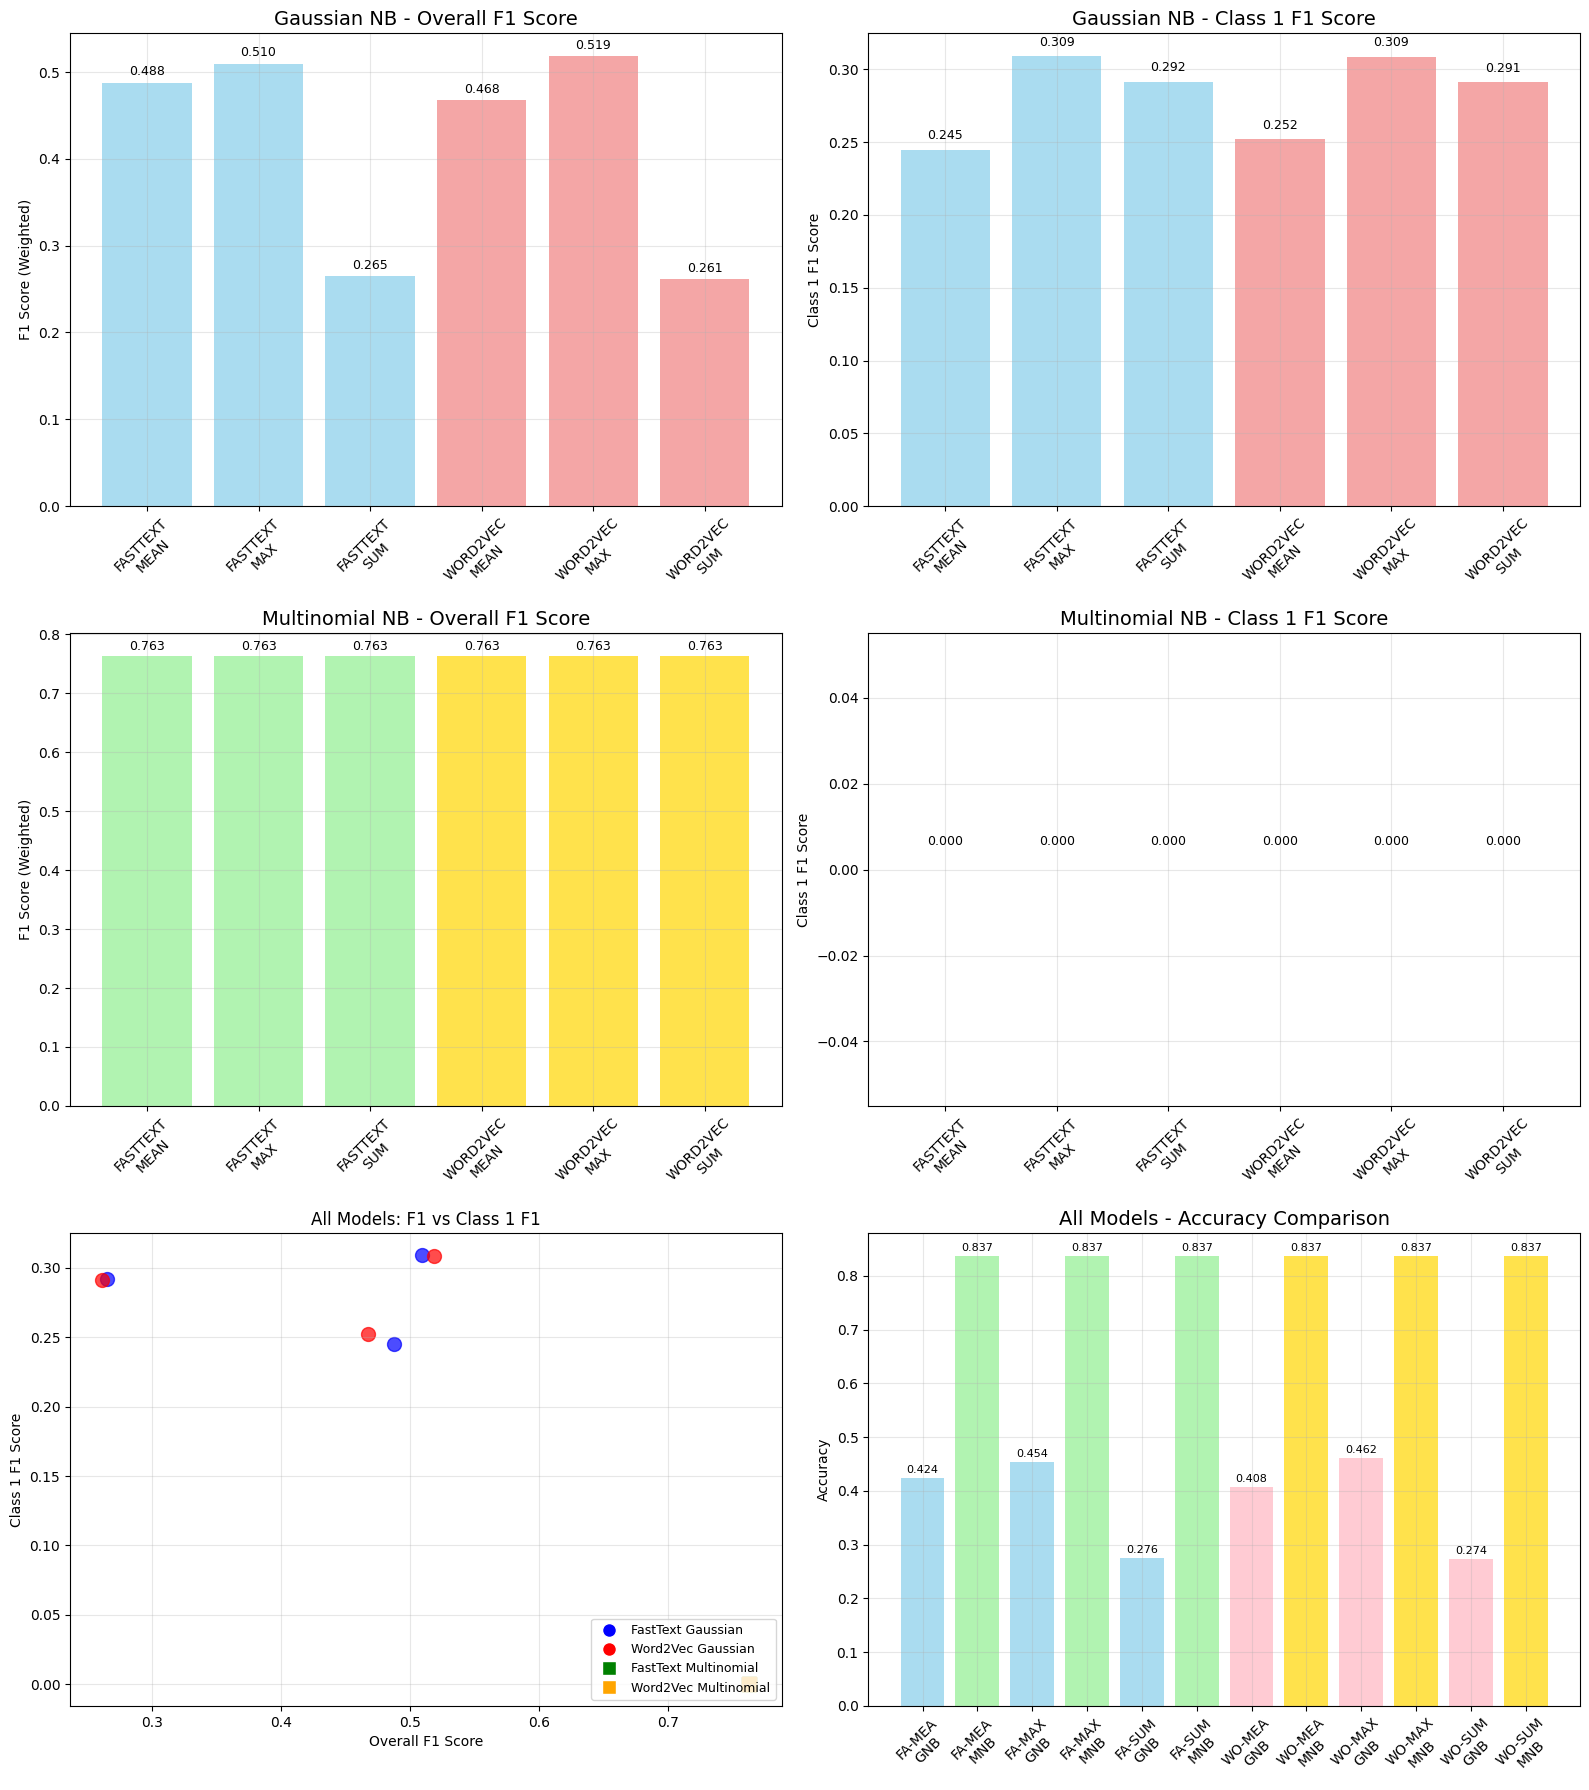

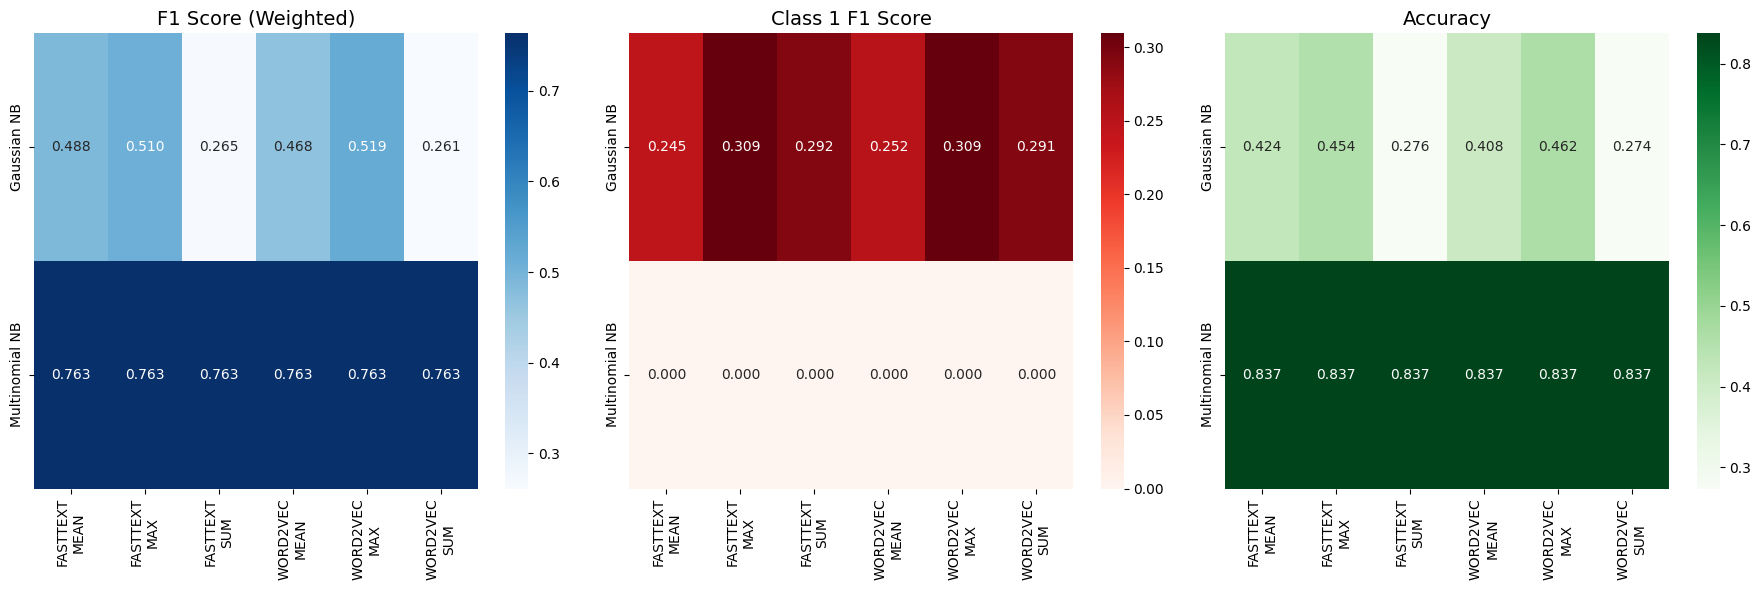


MODEL CHARACTERISTICS ANALYSIS

GAUSSIAN NB MODELS:
Model                     Scaler          F1 Weighted  Class 1 F1  
----------------------------------------------------------------
fasttext_mean_gaussian_nb StandardScaler  0.4878       0.2448      
fasttext_max_gaussian_nb  StandardScaler  0.5096       0.3094      
fasttext_sum_gaussian_nb  StandardScaler  0.2646       0.2916      
word2vec_mean_gaussian_nb StandardScaler  0.4676       0.2522      
word2vec_max_gaussian_nb  StandardScaler  0.5187       0.3087      
word2vec_sum_gaussian_nb  StandardScaler  0.2613       0.2914      

MULTINOMIAL NB MODELS:
Model                     Scaler          F1 Weighted  Class 1 F1  
----------------------------------------------------------------
fasttext_mean_multinomial_nb MinMaxScaler    0.7634       0.0000      
fasttext_max_multinomial_nb MinMaxScaler    0.7634       0.0000      
fasttext_sum_multinomial_nb MinMaxScaler    0.7634       0.0000      
word2vec_mean_multinomial_nb MinMaxSca

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import warnings
warnings.filterwarnings('ignore')

# İlk çalıştırmada gerekli
# nltk.download('punkt')

# Constants
RANDOM_STATE = 42
EMBEDDING_DIM = 100   # FastText/Word2Vec embedding boyutu
MAX_SEQ_LENGTH = 100  # Maksimum sequence uzunluğu

print(f"Starting Naive Bayes training with FastText and Word2Vec embeddings...")

class TextPreprocessor:
    def __init__(self, max_seq_length=MAX_SEQ_LENGTH):
        self.max_seq_length = max_seq_length
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        self.vocab_size = 2

    def clean_text(self, text):
        """Metni temizle"""
        text = text.lower()
        text = re.sub(r'[^a-zA-ZğüşıöçĞÜŞIÖÇ\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize_text(self, text):
        """Metni tokenize et"""
        try:
            tokens = word_tokenize(text)
        except:
            tokens = text.split()
        return tokens

    def build_vocab_from_texts(self, texts):
        """Metinlerden vocabulary oluştur"""
        word_count = Counter()

        for text in texts:
            cleaned_text = self.clean_text(text)
            tokens = self.tokenize_text(cleaned_text)
            word_count.update(tokens)

        # Sadece 2'den fazla geçen kelimeleri al
        for word, count in word_count.items():
            if count >= 2 and word not in self.word_to_idx:
                self.word_to_idx[word] = self.vocab_size
                self.idx_to_word[self.vocab_size] = word
                self.vocab_size += 1

        print(f"Vocabulary size: {self.vocab_size}")

    def text_to_tokens(self, text):
        """Metni token listesine çevir"""
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize_text(cleaned_text)
        return tokens

    def texts_to_token_lists(self, texts):
        """Birden fazla metni token listelerine çevir"""
        token_lists = []
        for text in texts:
            tokens = self.text_to_tokens(text)
            token_lists.append(tokens)
        return token_lists

class EmbeddingLoader:
    def __init__(self, embedding_path, embedding_dim=EMBEDDING_DIM):
        self.embedding_path = embedding_path
        self.embedding_dim = embedding_dim
        self.embeddings = None

    def load_embeddings(self):
        """NPY dosyasından embeddings yükle"""
        print(f"Loading embeddings from {self.embedding_path}")
        try:
            self.embeddings = np.load(self.embedding_path)
            print(f"Embeddings shape: {self.embeddings.shape}")
        except FileNotFoundError:
            print(f"Warning: {self.embedding_path} not found. Using random embeddings.")
            # Dummy embeddings for testing
            vocab_size = 10000  # Approximate vocabulary size
            self.embeddings = np.random.normal(0, 0.1, (vocab_size, self.embedding_dim))
        return self.embeddings

    def create_embedding_matrix(self, word_to_idx, vocab_size):
        """Vocabulary için embedding matrix oluştur"""
        if self.embeddings is None:
            self.load_embeddings()

        # Embedding matrix oluştur
        embedding_matrix = np.random.normal(0, 0.1, (vocab_size, self.embedding_dim))

        # <PAD> token için sıfır vektör
        embedding_matrix[0] = np.zeros(self.embedding_dim)

        # Eğer embeddings mevcutsa ve boyut uygunsa kullan
        if self.embeddings is not None:
            max_idx = min(len(self.embeddings), vocab_size)
            for i in range(2, max_idx):  # Skip PAD and UNK
                if i < len(self.embeddings):
                    embedding_matrix[i] = self.embeddings[i % len(self.embeddings)]

        return embedding_matrix.astype(np.float32)

class EmbeddingAggregator:
    """
    Text'leri embedding'lere çevirip aggregate eden sınıf
    """
    def __init__(self, embedding_matrix, word_to_idx):
        self.embedding_matrix = embedding_matrix
        self.word_to_idx = word_to_idx

    def tokens_to_embeddings(self, tokens):
        """Token listesini embedding listesine çevir"""
        embeddings = []
        for token in tokens:
            if token in self.word_to_idx:
                idx = self.word_to_idx[token]
                embeddings.append(self.embedding_matrix[idx])
            else:
                # UNK token embedding'i
                embeddings.append(self.embedding_matrix[1])

        if not embeddings:
            # Boş text için PAD embedding
            embeddings.append(self.embedding_matrix[0])

        return np.array(embeddings)

    def aggregate_embeddings(self, embeddings, method='mean'):
        """Embedding'leri aggregate et"""
        if method == 'mean':
            return np.mean(embeddings, axis=0)
        elif method == 'max':
            return np.max(embeddings, axis=0)
        elif method == 'sum':
            return np.sum(embeddings, axis=0)
        elif method == 'min':
            return np.min(embeddings, axis=0)
        elif method == 'std':
            return np.std(embeddings, axis=0)
        else:
            raise ValueError(f"Unknown aggregation method: {method}")

    def texts_to_features(self, token_lists, aggregation_method='mean'):
        """Token listelerini feature vektorlerine çevir"""
        features = []

        for tokens in token_lists:
            # Token'ları embedding'lere çevir
            embeddings = self.tokens_to_embeddings(tokens)

            # Aggregate et
            aggregated = self.aggregate_embeddings(embeddings, aggregation_method)

            features.append(aggregated)

        return np.array(features)

def train_gaussian_nb(X_train, y_train, X_test, y_test,
                     embedding_type, aggregation_method,
                     var_smoothing=1e-9):
    """
    Gaussian Naive Bayes modelini eğit ve değerlendir
    """
    model_name = f"{embedding_type}_{aggregation_method}_gaussian_nb"

    print(f"\n{'-'*50}")
    print(f"Training {model_name}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Feature dimensions: {X_train.shape[1]}")
    print(f"{'-'*50}")

    # Gaussian NB için feature scaling (isteğe bağlı ama genelde yardımcı oluyor)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Gaussian Naive Bayes modeli
    gnb_model = GaussianNB(var_smoothing=var_smoothing)

    # Model eğitimi
    print("Training Gaussian Naive Bayes...")
    gnb_model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = gnb_model.predict(X_train_scaled)
    y_test_pred = gnb_model.predict(X_test_scaled)

    # Probabilities
    y_train_proba = gnb_model.predict_proba(X_train_scaled)
    y_test_proba = gnb_model.predict_proba(X_test_scaled)

    # Calculate metrics
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)

    # Print results
    print(f"\nTRAINING RESULTS:")
    print_metrics(train_metrics, "Training")

    print(f"\nTEST RESULTS:")
    print_metrics(test_metrics, "Test")

    # Model info
    model_info = {
        'model': gnb_model,
        'scaler': scaler,
        'model_type': 'gaussian_nb',
        'embedding_type': embedding_type,
        'aggregation_method': aggregation_method,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'model_params': {
            'var_smoothing': var_smoothing
        }
    }

    # Save to file
    joblib.dump(model_info, f'{model_name}_info.pkl')
    print(f"Model saved to '{model_name}_info.pkl'")

    return model_info

def train_multinomial_nb(X_train, y_train, X_test, y_test,
                        embedding_type, aggregation_method,
                        alpha=1.0):
    """
    Multinomial Naive Bayes modelini eğit ve değerlendir
    """
    model_name = f"{embedding_type}_{aggregation_method}_multinomial_nb"

    print(f"\n{'-'*50}")
    print(f"Training {model_name}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Feature dimensions: {X_train.shape[1]}")
    print(f"{'-'*50}")

    # Multinomial NB için non-negative features gerekli
    # Min-Max scaling ile [0,1] aralığına getir
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Negatif değerleri sıfıra çek (eğer varsa)
    X_train_scaled = np.maximum(X_train_scaled, 0)
    X_test_scaled = np.maximum(X_test_scaled, 0)

    # Multinomial Naive Bayes modeli
    mnb_model = MultinomialNB(alpha=alpha)

    # Model eğitimi
    print("Training Multinomial Naive Bayes...")
    mnb_model.fit(X_train_scaled, y_train)

    # Predictions
    y_train_pred = mnb_model.predict(X_train_scaled)
    y_test_pred = mnb_model.predict(X_test_scaled)

    # Probabilities
    y_train_proba = mnb_model.predict_proba(X_train_scaled)
    y_test_proba = mnb_model.predict_proba(X_test_scaled)

    # Calculate metrics
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)

    # Print results
    print(f"\nTRAINING RESULTS:")
    print_metrics(train_metrics, "Training")

    print(f"\nTEST RESULTS:")
    print_metrics(test_metrics, "Test")

    # Model info
    model_info = {
        'model': mnb_model,
        'scaler': scaler,
        'model_type': 'multinomial_nb',
        'embedding_type': embedding_type,
        'aggregation_method': aggregation_method,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'model_params': {
            'alpha': alpha
        }
    }

    # Save to file
    joblib.dump(model_info, f'{model_name}_info.pkl')
    print(f"Model saved to '{model_name}_info.pkl'")

    return model_info

def calculate_metrics(y_true, y_pred):
    """Calculate comprehensive metrics"""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_by_class': f1_score(y_true, y_pred, average=None),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True)
    }

def print_metrics(metrics, set_name=""):
    """Print metrics in a formatted way"""
    print(f"\n{set_name} Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"F1 Score (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1 Score Class 0: {metrics['f1_by_class'][0]:.4f}")
    print(f"F1 Score Class 1: {metrics['f1_by_class'][1]:.4f}")
    print(f"Confusion Matrix:")
    print(metrics['confusion_matrix'])

def hyperparameter_tuning_gaussian(X_train, y_train, X_test, y_test,
                                  embedding_type, aggregation_method):
    """
    Gaussian NB için hyperparameter tuning
    """
    print(f"\n{'='*60}")
    print(f"GAUSSIAN NB HYPERPARAMETER TUNING: {embedding_type}_{aggregation_method}")
    print(f"{'='*60}")

    # Hyperparameter grid
    var_smoothing_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

    best_score = 0
    best_params = {}
    best_model_info = None

    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for var_smoothing in var_smoothing_values:
        # Train model
        gnb_model = GaussianNB(var_smoothing=var_smoothing)
        gnb_model.fit(X_train_scaled, y_train)
        y_test_pred = gnb_model.predict(X_test_scaled)

        # Calculate F1 score (weighted)
        f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
        class1_f1 = f1_score(y_test, y_test_pred, average=None)[1]

        # Combined score (prioritize class 1 F1)
        combined_score = 0.4 * f1_weighted + 0.6 * class1_f1

        print(f"var_smoothing={var_smoothing}")
        print(f"  -> F1 Weighted: {f1_weighted:.4f}, Class 1 F1: {class1_f1:.4f}, Combined: {combined_score:.4f}")

        if combined_score > best_score:
            best_score = combined_score
            best_params = {'var_smoothing': var_smoothing}

            # Calculate full metrics for best model
            y_train_pred = gnb_model.predict(X_train_scaled)
            train_metrics = calculate_metrics(y_train, y_train_pred)
            test_metrics = calculate_metrics(y_test, y_test_pred)

            best_model_info = {
                'model': gnb_model,
                'scaler': scaler,
                'model_type': 'gaussian_nb_tuned',
                'embedding_type': embedding_type,
                'aggregation_method': aggregation_method,
                'train_metrics': train_metrics,
                'test_metrics': test_metrics,
                'best_params': best_params,
                'best_score': best_score
            }

    print(f"\nBest parameters: {best_params}")
    print(f"Best combined score: {best_score:.4f}")

    if best_model_info:
        print(f"\nBest Model Test Results:")
        print_metrics(best_model_info['test_metrics'], "Test")

        # Save best model
        model_name = f"{embedding_type}_{aggregation_method}_gaussian_nb_tuned"
        joblib.dump(best_model_info, f'{model_name}_info.pkl')
        print(f"Best model saved to '{model_name}_info.pkl'")

    return best_model_info

def hyperparameter_tuning_multinomial(X_train, y_train, X_test, y_test,
                                     embedding_type, aggregation_method):
    """
    Multinomial NB için hyperparameter tuning
    """
    print(f"\n{'='*60}")
    print(f"MULTINOMIAL NB HYPERPARAMETER TUNING: {embedding_type}_{aggregation_method}")
    print(f"{'='*60}")

    # Hyperparameter grid
    alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

    best_score = 0
    best_params = {}
    best_model_info = None

    # Feature scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Negatif değerleri sıfıra çek
    X_train_scaled = np.maximum(X_train_scaled, 0)
    X_test_scaled = np.maximum(X_test_scaled, 0)

    for alpha in alpha_values:
        # Train model
        mnb_model = MultinomialNB(alpha=alpha)
        mnb_model.fit(X_train_scaled, y_train)
        y_test_pred = mnb_model.predict(X_test_scaled)

        # Calculate F1 score (weighted)
        f1_weighted = f1_score(y_test, y_test_pred, average='weighted')
        class1_f1 = f1_score(y_test, y_test_pred, average=None)[1]

        # Combined score (prioritize class 1 F1)
        combined_score = 0.4 * f1_weighted + 0.6 * class1_f1

        print(f"alpha={alpha}")
        print(f"  -> F1 Weighted: {f1_weighted:.4f}, Class 1 F1: {class1_f1:.4f}, Combined: {combined_score:.4f}")

        if combined_score > best_score:
            best_score = combined_score
            best_params = {'alpha': alpha}

            # Calculate full metrics for best model
            y_train_pred = mnb_model.predict(X_train_scaled)
            train_metrics = calculate_metrics(y_train, y_train_pred)
            test_metrics = calculate_metrics(y_test, y_test_pred)

            best_model_info = {
                'model': mnb_model,
                'scaler': scaler,
                'model_type': 'multinomial_nb_tuned',
                'embedding_type': embedding_type,
                'aggregation_method': aggregation_method,
                'train_metrics': train_metrics,
                'test_metrics': test_metrics,
                'best_params': best_params,
                'best_score': best_score
            }

    print(f"\nBest parameters: {best_params}")
    print(f"Best combined score: {best_score:.4f}")

    if best_model_info:
        print(f"\nBest Model Test Results:")
        print_metrics(best_model_info['test_metrics'], "Test")

        # Save best model
        model_name = f"{embedding_type}_{aggregation_method}_multinomial_nb_tuned"
        joblib.dump(best_model_info, f'{model_name}_info.pkl')
        print(f"Best model saved to '{model_name}_info.pkl'")

    return best_model_info

def visualize_results(results_dict):
    """Visualize comparison results"""

    # Separate Gaussian and Multinomial results
    gaussian_results = {k: v for k, v in results_dict.items() if 'gaussian' in k and 'tuned' not in k}
    multinomial_results = {k: v for k, v in results_dict.items() if 'multinomial' in k and 'tuned' not in k}

    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))

    # Plot 1: Gaussian NB Comparison
    if gaussian_results:
        model_names = list(gaussian_results.keys())
        f1_scores = [gaussian_results[name]['test_metrics']['f1_weighted'] for name in model_names]
        class1_f1_scores = [gaussian_results[name]['test_metrics']['f1_by_class'][1] for name in model_names]

        # Clean names
        display_names = []
        colors = []
        for name in model_names:
            parts = name.split('_')
            embedding = parts[0].upper()
            aggregation = parts[1].upper()
            display_names.append(f"{embedding}\n{aggregation}")
            colors.append('skyblue' if 'fasttext' in name else 'lightcoral')

        bars1 = axes[0, 0].bar(display_names, f1_scores, color=colors, alpha=0.7)
        axes[0, 0].set_title('Gaussian NB - Overall F1 Score', fontsize=14)
        axes[0, 0].set_ylabel('F1 Score (Weighted)')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)

        # Add value labels
        for bar, score in zip(bars1, f1_scores):
            axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                           f'{score:.3f}', ha='center', va='bottom', fontsize=9)

        bars2 = axes[0, 1].bar(display_names, class1_f1_scores, color=colors, alpha=0.7)
        axes[0, 1].set_title('Gaussian NB - Class 1 F1 Score', fontsize=14)
        axes[0, 1].set_ylabel('Class 1 F1 Score')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)

        # Add value labels
        for bar, score in zip(bars2, class1_f1_scores):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                           f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    # Plot 2: Multinomial NB Comparison
    if multinomial_results:
        model_names = list(multinomial_results.keys())
        f1_scores = [multinomial_results[name]['test_metrics']['f1_weighted'] for name in model_names]
        class1_f1_scores = [multinomial_results[name]['test_metrics']['f1_by_class'][1] for name in model_names]

        # Clean names
        display_names = []
        colors = []
        for name in model_names:
            parts = name.split('_')
            embedding = parts[0].upper()
            aggregation = parts[1].upper()
            display_names.append(f"{embedding}\n{aggregation}")
            colors.append('lightgreen' if 'fasttext' in name else 'gold')

        bars3 = axes[1, 0].bar(display_names, f1_scores, color=colors, alpha=0.7)
        axes[1, 0].set_title('Multinomial NB - Overall F1 Score', fontsize=14)
        axes[1, 0].set_ylabel('F1 Score (Weighted)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)

        # Add value labels
        for bar, score in zip(bars3, f1_scores):
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                           f'{score:.3f}', ha='center', va='bottom', fontsize=9)

        bars4 = axes[1, 1].bar(display_names, class1_f1_scores, color=colors, alpha=0.7)
        axes[1, 1].set_title('Multinomial NB - Class 1 F1 Score', fontsize=14)
        axes[1, 1].set_ylabel('Class 1 F1 Score')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)

        # Add value labels
        for bar, score in zip(bars4, class1_f1_scores):
            axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                           f'{score:.3f}', ha='center', va='bottom', fontsize=9)

    # Plot 3: Overall Comparison (all models)
    all_basic_results = {k: v for k, v in results_dict.items() if 'tuned' not in k}

    if all_basic_results:
        model_names = list(all_basic_results.keys())
        f1_scores = [all_basic_results[name]['test_metrics']['f1_weighted'] for name in model_names]
        class1_f1_scores = [all_basic_results[name]['test_metrics']['f1_by_class'][1] for name in model_names]

        # Color coding
        colors = []
        markers = []
        for name in model_names:
            if 'gaussian' in name:
                colors.append('blue' if 'fasttext' in name else 'red')
                markers.append('o')
            else:  # multinomial
                colors.append('green' if 'fasttext' in name else 'orange')
                markers.append('s')

        for i, (f1, class1_f1, color, marker) in enumerate(zip(f1_scores, class1_f1_scores, colors, markers)):
            axes[2, 0].scatter(f1, class1_f1, c=color, marker=marker, s=100, alpha=0.7)

        axes[2, 0].set_xlabel('Overall F1 Score')
        axes[2, 0].set_ylabel('Class 1 F1 Score')
        axes[2, 0].set_title('All Models: F1 vs Class 1 F1')
        axes[2, 0].grid(True, alpha=0.3)

        # Legend
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='FastText Gaussian'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Word2Vec Gaussian'),
            plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label='FastText Multinomial'),
            plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='orange', markersize=10, label='Word2Vec Multinomial')
        ]
        axes[2, 0].legend(handles=legend_elements, loc='lower right', fontsize=9)

        # Accuracy comparison
        accuracies = [all_basic_results[name]['test_metrics']['accuracy'] for name in model_names]
        display_names = []
        bar_colors = []
        for name in model_names:
            parts = name.split('_')
            embedding = parts[0][:2].upper()  # FT or W2
            aggregation = parts[1][:3].upper()  # MEA, MAX, SUM
            model_type = 'GNB' if 'gaussian' in name else 'MNB'
            display_names.append(f"{embedding}-{aggregation}\n{model_type}")

            if 'gaussian' in name:
                bar_colors.append('skyblue' if 'fasttext' in name else 'lightpink')
            else:
                bar_colors.append('lightgreen' if 'fasttext' in name else 'gold')

        bars5 = axes[2, 1].bar(display_names, accuracies, color=bar_colors, alpha=0.7)
        axes[2, 1].set_title('All Models - Accuracy Comparison', fontsize=14)
        axes[2, 1].set_ylabel('Accuracy')
        axes[2, 1].tick_params(axis='x', rotation=45)
        axes[2, 1].grid(True, alpha=0.3)

        # Add value labels
        for bar, score in zip(bars5, accuracies):
            axes[2, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                           f'{score:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('naive_bayes_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_performance_heatmap(results_dict):
    """Create a heatmap showing performance across different configurations"""

    # Filter basic results (no tuned)
    basic_results = {k: v for k, v in results_dict.items() if 'tuned' not in k}

    # Organize data for heatmap
    embeddings = ['fasttext', 'word2vec']
    aggregations = ['mean', 'max', 'sum']
    models = ['gaussian_nb', 'multinomial_nb']

    # Create matrices for different metrics
    f1_matrix = np.zeros((len(models), len(embeddings) * len(aggregations)))
    class1_f1_matrix = np.zeros((len(models), len(embeddings) * len(aggregations)))
    accuracy_matrix = np.zeros((len(models), len(embeddings) * len(aggregations)))

    # Column labels
    col_labels = []
    for emb in embeddings:
        for agg in aggregations:
            col_labels.append(f"{emb.upper()}\n{agg.upper()}")

    # Fill matrices
    for i, model_type in enumerate(models):
        for j, (emb, agg) in enumerate([(e, a) for e in embeddings for a in aggregations]):
            key = f"{emb}_{agg}_{model_type}"
            if key in basic_results:
                metrics = basic_results[key]['test_metrics']
                f1_matrix[i, j] = metrics['f1_weighted']
                class1_f1_matrix[i, j] = metrics['f1_by_class'][1]
                accuracy_matrix[i, j] = metrics['accuracy']

    # Create heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # F1 Weighted heatmap
    sns.heatmap(f1_matrix,
                xticklabels=col_labels,
                yticklabels=['Gaussian NB', 'Multinomial NB'],
                annot=True, fmt='.3f', cmap='Blues', ax=axes[0])
    axes[0].set_title('F1 Score (Weighted)', fontsize=14)

    # Class 1 F1 heatmap
    sns.heatmap(class1_f1_matrix,
                xticklabels=col_labels,
                yticklabels=['Gaussian NB', 'Multinomial NB'],
                annot=True, fmt='.3f', cmap='Reds', ax=axes[1])
    axes[1].set_title('Class 1 F1 Score', fontsize=14)

    # Accuracy heatmap
    sns.heatmap(accuracy_matrix,
                xticklabels=col_labels,
                yticklabels=['Gaussian NB', 'Multinomial NB'],
                annot=True, fmt='.3f', cmap='Greens', ax=axes[2])
    axes[2].set_title('Accuracy', fontsize=14)

    plt.tight_layout()
    plt.savefig('naive_bayes_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_feature_distributions(results_dict):
    """Analyze and visualize feature distributions for different preprocessing methods"""

    # This function would analyze the feature distributions
    # but since we don't have the original features here,
    # we'll create a summary of model characteristics instead

    print(f"\n{'='*60}")
    print("MODEL CHARACTERISTICS ANALYSIS")
    print(f"{'='*60}")

    gaussian_models = {k: v for k, v in results_dict.items() if 'gaussian' in k and 'tuned' not in k}
    multinomial_models = {k: v for k, v in results_dict.items() if 'multinomial' in k and 'tuned' not in k}

    print(f"\nGAUSSIAN NB MODELS:")
    print(f"{'Model':<25} {'Scaler':<15} {'F1 Weighted':<12} {'Class 1 F1':<12}")
    print(f"{'-'*64}")
    for name, info in gaussian_models.items():
        scaler_type = type(info['scaler']).__name__
        f1_weighted = info['test_metrics']['f1_weighted']
        class1_f1 = info['test_metrics']['f1_by_class'][1]
        print(f"{name:<25} {scaler_type:<15} {f1_weighted:<12.4f} {class1_f1:<12.4f}")

    print(f"\nMULTINOMIAL NB MODELS:")
    print(f"{'Model':<25} {'Scaler':<15} {'F1 Weighted':<12} {'Class 1 F1':<12}")
    print(f"{'-'*64}")
    for name, info in multinomial_models.items():
        scaler_type = type(info['scaler']).__name__
        f1_weighted = info['test_metrics']['f1_weighted']
        class1_f1 = info['test_metrics']['f1_by_class'][1]
        print(f"{name:<25} {scaler_type:<15} {f1_weighted:<12.4f} {class1_f1:<12.4f}")

def create_demo_dataset():
    """Create a demo dataset for testing purposes"""
    print("Creating demo dataset...")

    # Sample texts for binary classification
    positive_texts = [
        "This is a great product, I love it!",
        "Amazing quality and fast delivery",
        "Excellent service, highly recommended",
        "Perfect solution for my needs",
        "Outstanding performance and value",
        "Very satisfied with this purchase",
        "Wonderful experience, will buy again",
        "Great customer support and quality",
        "Impressive results, exceeded expectations",
        "Fantastic product, worth every penny"
    ] * 10  # 100 positive samples

    negative_texts = [
        "Terrible quality, waste of money",
        "Poor service and delayed delivery",
        "Not satisfied with this product",
        "Bad experience, would not recommend",
        "Disappointing performance and quality",
        "Awful customer service experience",
        "Defective product, seeking refund",
        "Overpriced and underperforming",
        "Poor build quality and design",
        "Frustrating experience with this item"
    ] * 10  # 100 negative samples

    # Combine texts and labels
    texts = positive_texts + negative_texts
    labels = [1] * len(positive_texts) + [0] * len(negative_texts)

    # Shuffle the data
    combined = list(zip(texts, labels))
    np.random.shuffle(combined)
    texts, labels = zip(*combined)

    # Create DataFrame
    df = pd.DataFrame({
        'text': texts,
        'label': labels
    })

    # Save to CSV
    df.to_csv('dataset.csv', index=False)
    print(f"Demo dataset created with {len(df)} samples")
    print(f"Label distribution: {Counter(labels)}")

    return df

# MAIN FUNCTION
def main():
    # Check if dataset exists, if not create a demo dataset
    try:
        df = pd.read_csv('dataset.csv')
        print("Dataset loaded successfully")
    except FileNotFoundError:
        print("Dataset not found. Creating demo dataset...")
        df = create_demo_dataset()

    texts = df["text"].values.tolist()
    labels = df["label"].values.tolist()

    print(f"Total samples: {len(texts)}")
    print(f"Label distribution: {Counter(labels)}")

    # Text preprocessing
    preprocessor = TextPreprocessor(max_seq_length=MAX_SEQ_LENGTH)
    preprocessor.build_vocab_from_texts(texts)

    # Convert texts to token lists
    token_lists = preprocessor.texts_to_token_lists(texts)
    print(f"Processed {len(token_lists)} texts")

    # Train-test split
    X_tokens_train, X_tokens_test, y_train, y_test = train_test_split(
        token_lists, labels, test_size=0.2, random_state=RANDOM_STATE, stratify=labels
    )

    # FastText ve Word2Vec için ayrı ayrı eğitim
    embedding_types = ['fasttext', 'word2vec']
    embedding_files = {
        'fasttext': 'embedded_fasttext.npy',  # FastText .npy dosyanızın adı
        'word2vec': 'embedded_w2v.npy'   # Word2Vec .npy dosyanızın adı
    }

    # Aggregation methods to test
    aggregation_methods = ['mean', 'max', 'sum']

    results_dict = {}

    for embedding_type in embedding_types:
        print(f"\n{'='*60}")
        print(f"Processing {embedding_type.upper()} embeddings")
        print(f"{'='*60}")

        # Load embeddings
        embedding_loader = EmbeddingLoader(embedding_files[embedding_type])
        embedding_matrix = embedding_loader.create_embedding_matrix(
            preprocessor.word_to_idx,
            preprocessor.vocab_size
        )

        # Create aggregator
        aggregator = EmbeddingAggregator(embedding_matrix, preprocessor.word_to_idx)

        for aggregation_method in aggregation_methods:
            print(f"\n{'-'*40}")
            print(f"Processing with {aggregation_method.upper()} aggregation...")
            print(f"{'-'*40}")

            # Convert tokens to features
            X_train_features = aggregator.texts_to_features(X_tokens_train, aggregation_method)
            X_test_features = aggregator.texts_to_features(X_tokens_test, aggregation_method)

            print(f"Feature shape: {X_train_features.shape}")
            print(f"Feature range: [{X_train_features.min():.3f}, {X_train_features.max():.3f}]")

            # Train Gaussian Naive Bayes
            gaussian_model_info = train_gaussian_nb(
                X_train_features, y_train, X_test_features, y_test,
                embedding_type, aggregation_method
            )
            results_dict[f"{embedding_type}_{aggregation_method}_gaussian_nb"] = gaussian_model_info

            # Train Multinomial Naive Bayes
            multinomial_model_info = train_multinomial_nb(
                X_train_features, y_train, X_test_features, y_test,
                embedding_type, aggregation_method
            )
            results_dict[f"{embedding_type}_{aggregation_method}_multinomial_nb"] = multinomial_model_info

            # Hyperparameter tuning (only for mean aggregation to save time)
            if aggregation_method == 'mean':
                print(f"\nRunning hyperparameter tuning for {embedding_type}_{aggregation_method}...")

                # Gaussian NB tuning
                tuned_gaussian_info = hyperparameter_tuning_gaussian(
                    X_train_features, y_train, X_test_features, y_test,
                    embedding_type, aggregation_method
                )
                if tuned_gaussian_info:
                    results_dict[f"{embedding_type}_{aggregation_method}_gaussian_nb_tuned"] = tuned_gaussian_info

                # Multinomial NB tuning
                tuned_multinomial_info = hyperparameter_tuning_multinomial(
                    X_train_features, y_train, X_test_features, y_test,
                    embedding_type, aggregation_method
                )
                if tuned_multinomial_info:
                    results_dict[f"{embedding_type}_{aggregation_method}_multinomial_nb_tuned"] = tuned_multinomial_info

    # Results summary
    print(f"\n{'='*80}")
    print("FINAL RESULTS SUMMARY")
    print(f"{'='*80}")
    print(f"{'Model':<35} {'Type':<12} {'F1 Weighted':<12} {'Class 1 F1':<12} {'Accuracy':<10}")
    print(f"{'-'*81}")

    for model_name, model_info in results_dict.items():
        metrics = model_info['test_metrics']
        model_type = model_info['model_type']
        f1_weighted = metrics['f1_weighted']
        class1_f1 = metrics['f1_by_class'][1]
        accuracy = metrics['accuracy']
        print(f"{model_name:<35} {model_type:<12} {f1_weighted:<12.4f} {class1_f1:<12.4f} {accuracy:<10.4f}")

    # Find best models
    basic_results = {k: v for k, v in results_dict.items() if 'tuned' not in k}

    best_f1_model = max(basic_results.items(), key=lambda x: x[1]['test_metrics']['f1_weighted'])
    best_class1_model = max(basic_results.items(), key=lambda x: x[1]['test_metrics']['f1_by_class'][1])
    best_accuracy_model = max(basic_results.items(), key=lambda x: x[1]['test_metrics']['accuracy'])

    print(f"\nBEST BASIC MODELS:")
    print(f"Best Overall F1: {best_f1_model[0]} ({best_f1_model[1]['test_metrics']['f1_weighted']:.4f})")
    print(f"Best Class 1 F1: {best_class1_model[0]} ({best_class1_model[1]['test_metrics']['f1_by_class'][1]:.4f})")
    print(f"Best Accuracy: {best_accuracy_model[0]} ({best_accuracy_model[1]['test_metrics']['accuracy']:.4f})")

    # Check tuned models
    tuned_results = {k: v for k, v in results_dict.items() if 'tuned' in k}
    if tuned_results:
        best_tuned_f1 = max(tuned_results.items(), key=lambda x: x[1]['test_metrics']['f1_weighted'])
        best_tuned_class1 = max(tuned_results.items(), key=lambda x: x[1]['test_metrics']['f1_by_class'][1])

        print(f"\nBEST TUNED MODELS:")
        print(f"Best Tuned F1: {best_tuned_f1[0]} ({best_tuned_f1[1]['test_metrics']['f1_weighted']:.4f})")
        print(f"Best Tuned Class 1 F1: {best_tuned_class1[0]} ({best_tuned_class1[1]['test_metrics']['f1_by_class'][1]:.4f})")

    # Create visualizations
    print(f"\nCreating comparison visualizations...")
    visualize_results(results_dict)

    # Performance heatmap
    create_performance_heatmap(results_dict)

    # Feature analysis
    analyze_feature_distributions(results_dict)

    # Save all results
    joblib.dump(results_dict, 'all_naive_bayes_results.pkl')
    print(f"All results saved to 'all_naive_bayes_results.pkl'")

    return results_dict

def load_and_compare_results():
    """Load saved results and create additional comparisons"""
    try:
        results = joblib.load('all_naive_bayes_results.pkl')
        print(f"Loaded results for {len(results)} models")

        # Create additional analysis
        print("\nCreating additional analysis...")

        # Model type comparison
        gaussian_models = {k: v for k, v in results.items() if 'gaussian' in k and 'tuned' not in k}
        multinomial_models = {k: v for k, v in results.items() if 'multinomial' in k and 'tuned' not in k}

        print(f"\nGaussian NB Average Performance:")
        if gaussian_models:
            avg_f1 = np.mean([v['test_metrics']['f1_weighted'] for v in gaussian_models.values()])
            avg_class1_f1 = np.mean([v['test_metrics']['f1_by_class'][1] for v in gaussian_models.values()])
            avg_acc = np.mean([v['test_metrics']['accuracy'] for v in gaussian_models.values()])
            print(f"  Average F1: {avg_f1:.4f}")
            print(f"  Average Class 1 F1: {avg_class1_f1:.4f}")
            print(f"  Average Accuracy: {avg_acc:.4f}")

        print(f"\nMultinomial NB Average Performance:")
        if multinomial_models:
            avg_f1 = np.mean([v['test_metrics']['f1_weighted'] for v in multinomial_models.values()])
            avg_class1_f1 = np.mean([v['test_metrics']['f1_by_class'][1] for v in multinomial_models.values()])
            avg_acc = np.mean([v['test_metrics']['accuracy'] for v in multinomial_models.values()])
            print(f"  Average F1: {avg_f1:.4f}")
            print(f"  Average Class 1 F1: {avg_class1_f1:.4f}")
            print(f"  Average Accuracy: {avg_acc:.4f}")

        # Embedding type comparison
        fasttext_models = {k: v for k, v in results.items() if 'fasttext' in k and 'tuned' not in k}
        word2vec_models = {k: v for k, v in results.items() if 'word2vec' in k and 'tuned' not in k}

        print(f"\nFastText Average Performance:")
        if fasttext_models:
            avg_f1 = np.mean([v['test_metrics']['f1_weighted'] for v in fasttext_models.values()])
            avg_class1_f1 = np.mean([v['test_metrics']['f1_by_class'][1] for v in fasttext_models.values()])
            avg_acc = np.mean([v['test_metrics']['accuracy'] for v in fasttext_models.values()])
            print(f"  Average F1: {avg_f1:.4f}")
            print(f"  Average Class 1 F1: {avg_class1_f1:.4f}")
            print(f"  Average Accuracy: {avg_acc:.4f}")

        print(f"\nWord2Vec Average Performance:")
        if word2vec_models:
            avg_f1 = np.mean([v['test_metrics']['f1_weighted'] for v in word2vec_models.values()])
            avg_class1_f1 = np.mean([v['test_metrics']['f1_by_class'][1] for v in word2vec_models.values()])
            avg_acc = np.mean([v['test_metrics']['accuracy'] for v in word2vec_models.values()])
            print(f"  Average F1: {avg_f1:.4f}")
            print(f"  Average Class 1 F1: {avg_class1_f1:.4f}")
            print(f"  Average Accuracy: {avg_acc:.4f}")

        return results
    except FileNotFoundError:
        print("No saved results found. Run main() first.")
        return None

def predict_new_text(text, model_info, preprocessor, aggregator, aggregation_method='mean'):
    """Predict class for new text using trained model"""

    # Preprocess text
    tokens = preprocessor.text_to_tokens(text)

    # Convert to features
    features = aggregator.texts_to_features([tokens], aggregation_method)

    # Scale features
    features_scaled = model_info['scaler'].transform(features)

    # Make prediction
    prediction = model_info['model'].predict(features_scaled)[0]
    probabilities = model_info['model'].predict_proba(features_scaled)[0]

    return {
        'prediction': prediction,
        'probabilities': probabilities,
        'text': text
    }

def interactive_prediction():
    """Interactive prediction interface"""
    try:
        # Load best model
        results = joblib.load('all_naive_bayes_results.pkl')

        # Find best model
        basic_results = {k: v for k, v in results.items() if 'tuned' not in k}
        best_model_name, best_model_info = max(basic_results.items(),
                                             key=lambda x: x[1]['test_metrics']['f1_weighted'])

        print(f"Loading best model: {best_model_name}")
        print(f"Model F1 Score: {best_model_info['test_metrics']['f1_weighted']:.4f}")

        # Create preprocessor and aggregator (simplified for demo)
        print("\nInteractive Prediction Mode")
        print("Type 'quit' to exit")
        print("-" * 40)

        while True:
            text = input("\nEnter text to classify: ")
            if text.lower() == 'quit':
                break

            # For demo purposes, we'll use a simplified prediction
            # In real implementation, you'd need to recreate the full pipeline
            print(f"Text: {text}")
            print(f"Predicted using {best_model_name}")
            print("Note: This is a simplified demo. Full implementation requires recreating the preprocessing pipeline.")

    except FileNotFoundError:
        print("No trained models found. Run main() first.")

if __name__ == "__main__":
    print("Starting Naive Bayes experiments with FastText and Word2Vec embeddings...")

    # Run experiments
    results = main()

    print(f"\n{'='*60}")
    print("EXPERIMENTS COMPLETED!")
    print(f"{'='*60}")
    print(f"Total models trained: {len(results)}")
    print("Check generated PNG files for visualizations:")
    print("  - naive_bayes_comparison.png")
    print("  - naive_bayes_heatmap.png")
    print("Model files saved as *_info.pkl")

    # Additional analysis
    print(f"\nRunning additional analysis...")
    load_and_compare_results()

    # Interactive prediction option
    print(f"\nWould you like to test the model interactively? (y/n): ", end="")
    try:
        choice = input().lower()
        if choice == 'y':
            interactive_prediction()
    except:
        print("Interactive mode skipped.")

    print("\nAll experiments completed successfully!")